In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize
from scipy.special import gamma
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scienceplots
from joblib import Parallel, delayed

plt.style.use(['science', 'notebook', 'grid'])

In [2]:
def studentpdf(epsilon, nu):
    return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)

class GARCHModel:
    def __init__(self, model_type):
        self.model_type = model_type
        self.parameters = None


    def fit(self, returns):
        if self.model_type == 'GARCH':
            initial_values = [np.mean(returns), np.var(returns) / 20, 0.10, 0.88, 6]
            bounds = [(None, None), (0, None), (0, None), (0, None), (2, 40)]
        elif self.model_type == 'Asymmetric GARCH':
            initial_values = [np.mean(returns), np.var(returns) / 20, 0.10, 0.10, 0.88, 6]
            bounds = [(None, None), (0, None), (0, None), (0, None), (0, None), (2, 40)]
        elif self.model_type == 'Symmetric Beta-t-EGARCH':
            initial_values = [np.mean(returns), 0, 0.95, 0.1, 0.0, 6]
            bounds = [(None, None), (None, None), (None, None), (None, None), (0, 0), (2, None)]
        elif self.model_type in 'Asymmetric Beta-t-EGARCH':
            initial_values = [np.mean(returns), 0, 0.95, 0.1, 0.1, 6]
            bounds = [(None, None), (None, None), (None, None), (None, None), (None, None), (2, None)]
        else:
            raise ValueError("Invalid model type")
        
        result = optimize.minimize(self.negative_log_likelihood, initial_values, args=(returns,), bounds=bounds, method='SLSQP')
        self.parameters = result.x
        return result


    def negative_log_likelihood(self, parameters, returns):
        mu = parameters[0]
        nu = parameters[-1]
        
        if self.model_type == 'GARCH':
            sigma_squared = self.garch(parameters, returns)
        elif self.model_type == 'Asymmetric GARCH':
            sigma_squared = self.asymmetric_garch(parameters, returns)
        elif self.model_type in ['Asymmetric Beta-t-EGARCH', 'Symmetric Beta-t-EGARCH']:
            sigma_squared, _, _ = self.asymmetric_beta_t_egarch(parameters, returns)
        else:
            raise ValueError("Invalid model type")
        
        epsilon = (returns - mu) / np.sqrt(sigma_squared + 1e-8)
        ll = -np.log(np.sqrt(sigma_squared + 1e-8)) + np.log(studentpdf(epsilon, nu))
        return -np.sum(ll)


    def garch(self, parameters, returns):
        mu, omega, alpha, beta, _ = parameters
        T = len(returns)
        sigma_squared = np.zeros(T)
        sigma_squared[0] = omega / (1 - alpha - beta)
        for t in range(1, T):
            sigma_squared[t] = omega + alpha * (returns[t - 1] - mu) ** 2 + beta * sigma_squared[t - 1]
        return sigma_squared


    def asymmetric_garch(self, parameters, returns):
        mu, omega, alpha_pos, alpha_neg, beta, _ = parameters
        T = len(returns)
        sigma_squared = np.zeros(T)
        initial_divisor = 1 - beta - alpha_pos / 2 - alpha_neg / 2
        sigma_squared[0] = omega / initial_divisor
        for t in range(1, T):
            epsilon_t = (returns[t-1] - mu)
            shock_effect = alpha_pos * (epsilon_t**2) if epsilon_t >= 0 else alpha_neg * (epsilon_t**2)
            sigma_squared[t] = omega + shock_effect + beta * sigma_squared[t-1]
        return sigma_squared


    def asymmetric_beta_t_egarch(self, parameters, returns):
        mu, lam, phi, kappa, kappa_tilde, nu = parameters
        T = len(returns)
        u = np.zeros(T)
        v = np.zeros(T)
        epsilon = np.zeros(T)
        lambdas = np.zeros(T)
        sigma = np.zeros(T)
        lambdas[0] = lam
        sigma[0] = np.exp(lam)
        epsilon[0] = (returns[0] - mu) / sigma[0]
        u[0] = np.sqrt((nu + 3) / (2 * nu)) * (((nu + 1) / (nu - 2 + epsilon[0]**2)) * epsilon[0]**2 - 1)
        v[0] = np.sqrt((nu + 2) * (nu + 3) / (nu + (nu + 1))) * ((nu + 1) / (nu - 2 + epsilon[0]**2)) * epsilon[0]
        for t in range(1, T):
            lambdas[t] = lam * (1 - phi) + phi * lambdas[t-1] + kappa * u[t-1] + kappa_tilde * v[t-1]
            sigma[t] = np.exp(lambdas[t])
            epsilon[t] = (returns[t] - mu) / sigma[t]
            u[t] = np.sqrt((nu + 3) / (2 * nu)) * (((nu + 1) / (nu - 2 + epsilon[t]**2)) * epsilon[t]**2 - 1)
            v[t] = np.sqrt((nu + 2) * (nu + 3) / (nu + (nu + 1))) * ((nu + 1) / (nu - 2 + epsilon[t]**2)) * epsilon[t]
        return sigma**2, u, v


    def forecast(self, returns, d):
        if self.model_type == 'GARCH':
            return self.PVolGARCH(returns, d)
        elif self.model_type == 'Asymmetric GARCH':
            return self.PVol_Asymmetric_GARCH(returns, d)
        elif self.model_type in ['Asymmetric Beta-t-EGARCH', 'Symmetric Beta-t-EGARCH']:
            return self.PVol_Asymmetric_Beta_t_GARCH(returns, d)
        else:
            raise ValueError("Invalid model type")


    def garch_forecast(self, returns, d):
        mu, omega, alpha, beta, _ = self.parameters
        sigma_squared = self.garch(self.parameters, returns)
        unconditional_var = omega / (1 - alpha - beta)
        d_day_forecast = unconditional_var + (alpha + beta)**(d-1) * (sigma_squared[1:] - unconditional_var)
        return d_day_forecast


    def PVol_Asymmetric_GARCH(self, returns, d):
        mu, omega, alpha_pos, alpha_neg, beta, _ = self.parameters
        sigma_squared = self.asymmetric_garch(self.parameters, returns)
        unconditional_var = omega / (1 - alpha_pos / 2 - alpha_neg / 2 - beta)
        predictions = d * (mu**2 + unconditional_var) + (1 - (alpha_pos / 2 + alpha_neg / 2 + beta)**d) / (1 - alpha_pos / 2 - alpha_neg / 2 - beta) * (sigma_squared[1:len(returns) - d + 1] - unconditional_var)
        return predictions
    
    
    def PVolGARCH(self, returns, h):
        mu, omega, alpha, beta, nu = self.parameters
        T = len(returns)
        sigma_squared = self.garch(self.parameters, returns)
        unconditional_var = omega / (1 - alpha - beta)
        predictions = h * (mu**2 + unconditional_var) + (1 - (alpha + beta)**h) / (1 - alpha - beta) * (sigma_squared[1:T - h + 1] - unconditional_var)
        return predictions


    def PVol_Asymmetric_Beta_t_GARCH(self, returns, h):
        mu, lam, phi, kappa, kappa_tilde, nu = self.parameters
        T = len(returns)
        pvol = np.zeros(T - h + 1)
        sigma_squared, u, v = self.asymmetric_beta_t_egarch(self.parameters, returns)
        for t in range(T - h):
            term1 = h * mu ** 2
            term2 = 0
            for d in range(1, h + 1):
                term2 += np.exp(
                    2 * lam + 2 * phi**(d - 1) * (np.log(np.sqrt(sigma_squared[t + 1])) - lam) +
                    2 * (kappa ** 2 + kappa_tilde ** 2) * (1 - phi ** (2 * (d - 1))) / (1 - phi ** 2)
                )
            pvol[t] = term1 + term2
        return pvol


# Utility functions
def plot_results(dates, returns, sigma_squared, model_name):
    plt.figure(figsize=(12, 6), dpi=300)
    plt.plot(dates, returns, 'k', label='Returns')
    plt.plot(dates, np.sqrt(sigma_squared), label=f'Estimated $\hat{{\sigma}}_{{t|t-1}}$ from {model_name} model')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.title(f'Returns and Estimated Volatility - {model_name}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_nic(epsilon, nic, model_name):
    plt.figure(figsize=(10, 5), dpi=300)
    plt.scatter(epsilon, nic, alpha=0.7)
    plt.xlabel('Implied residuals $\epsilon_t$')
    plt.ylabel('NIC')
    plt.title(f'News Impact Curve of the {model_name}')
    plt.grid(True) 
    plt.tight_layout()  
    plt.show()


def target_variable1(returns, d):
    T = len(returns) - d
    TV = np.zeros(T)
    for t in range(T):
        TV[t] = np.sum(returns[t+1:t+1+d]**2)
    return TV


def mincer_zarnowitz(actuals, forecasts):
    forecasts_sm = sm.add_constant(forecasts)
    model = sm.OLS(actuals, forecasts_sm)
    results = model.fit()
    return results

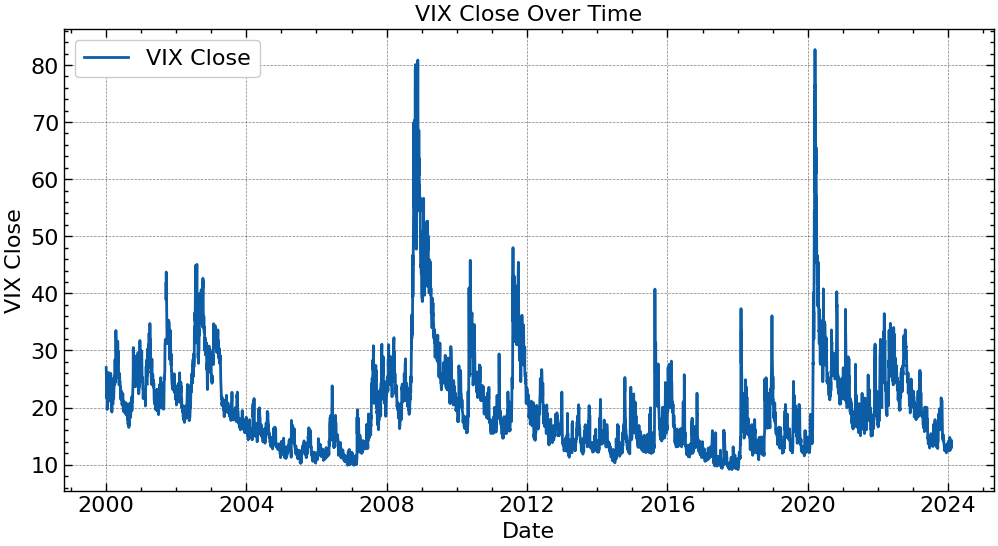

In [72]:
# Read data
data = pd.read_excel('data.xlsx', index_col='date', parse_dates=True)
returns = data['close-to-close log  return'].values
dates = pd.to_datetime(data.index, format='%Y%m%d')

# Plot VIX
plt.figure(figsize=(12, 6))
plt.plot(data['VIX close'], label='VIX Close')
plt.legend()
plt.title('VIX Close Over Time')
plt.xlabel('Date')
plt.ylabel('VIX Close')
plt.show()

# Symmetric GARCH

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:2: RuntimeWarning: divide by zero encountered in divide
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:2: RuntimeWarning: invalid value encountered in multiply
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:44: RuntimeWarning: invalid value encountered in sqrt
  epsilon = (returns - mu) / np.sqrt(sigma_squared + 1e-8)
/var/folders/4g/c51vp

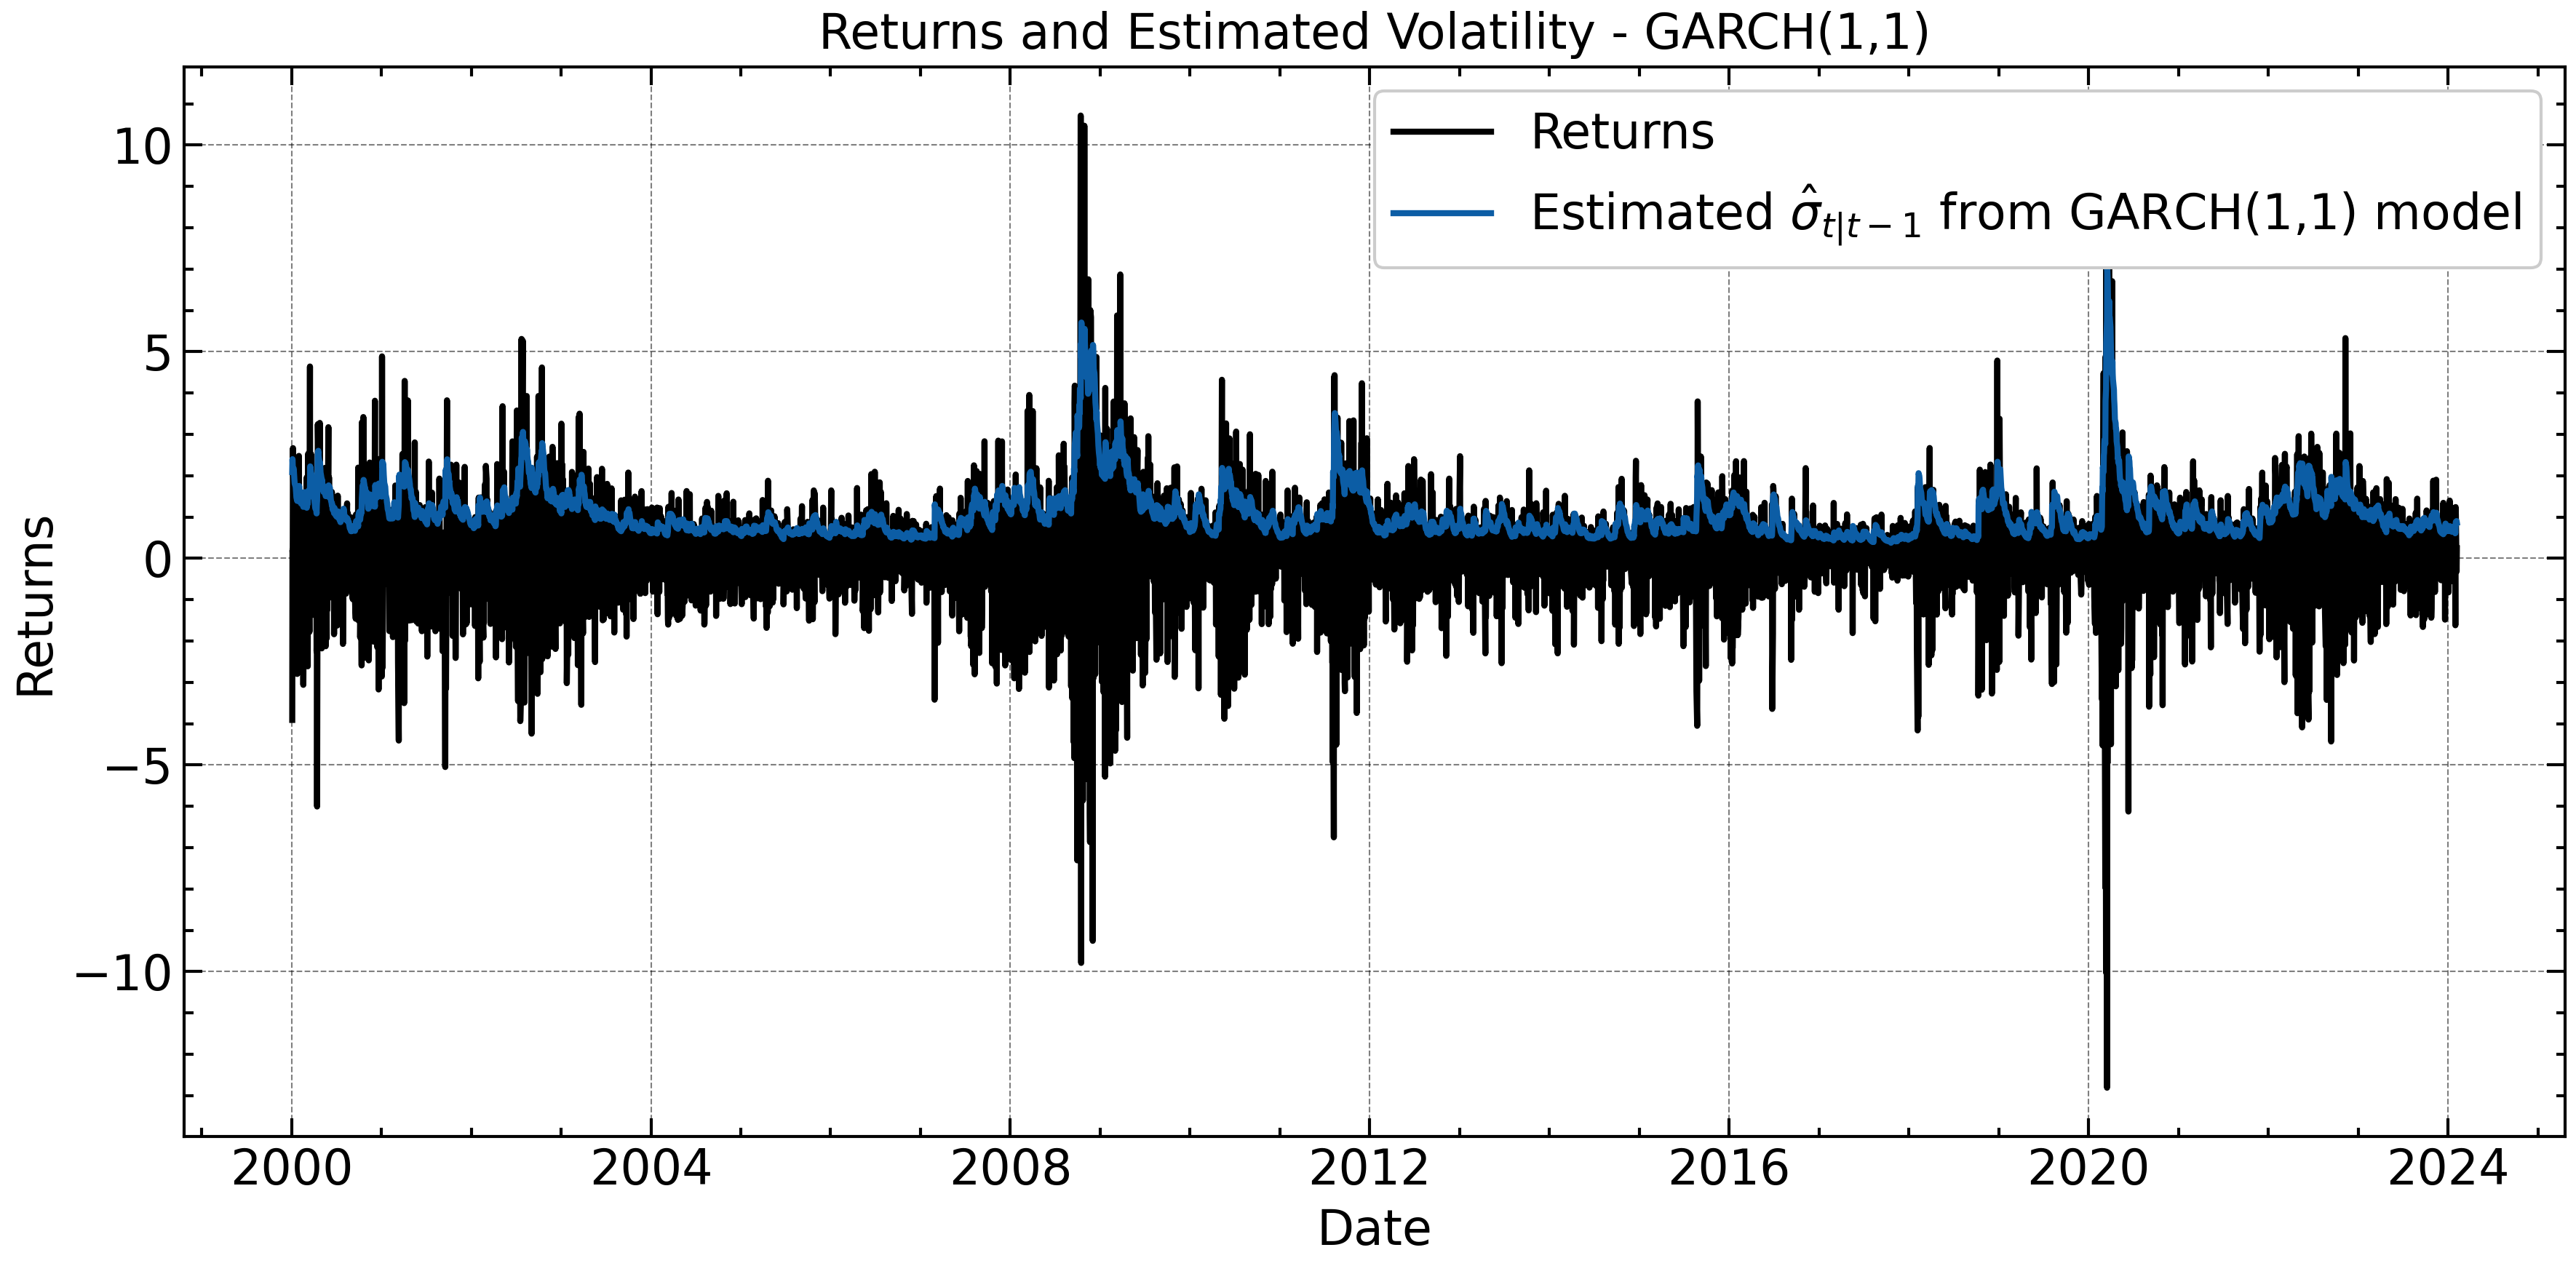

Optimization Successful: Yes
Estimated Parameters:
  mu    : 0.076
  omega : 0.013
  alpha : 0.121
  beta  : 0.876
  nu    : 6.470
Log-Likelihood: -8211.3


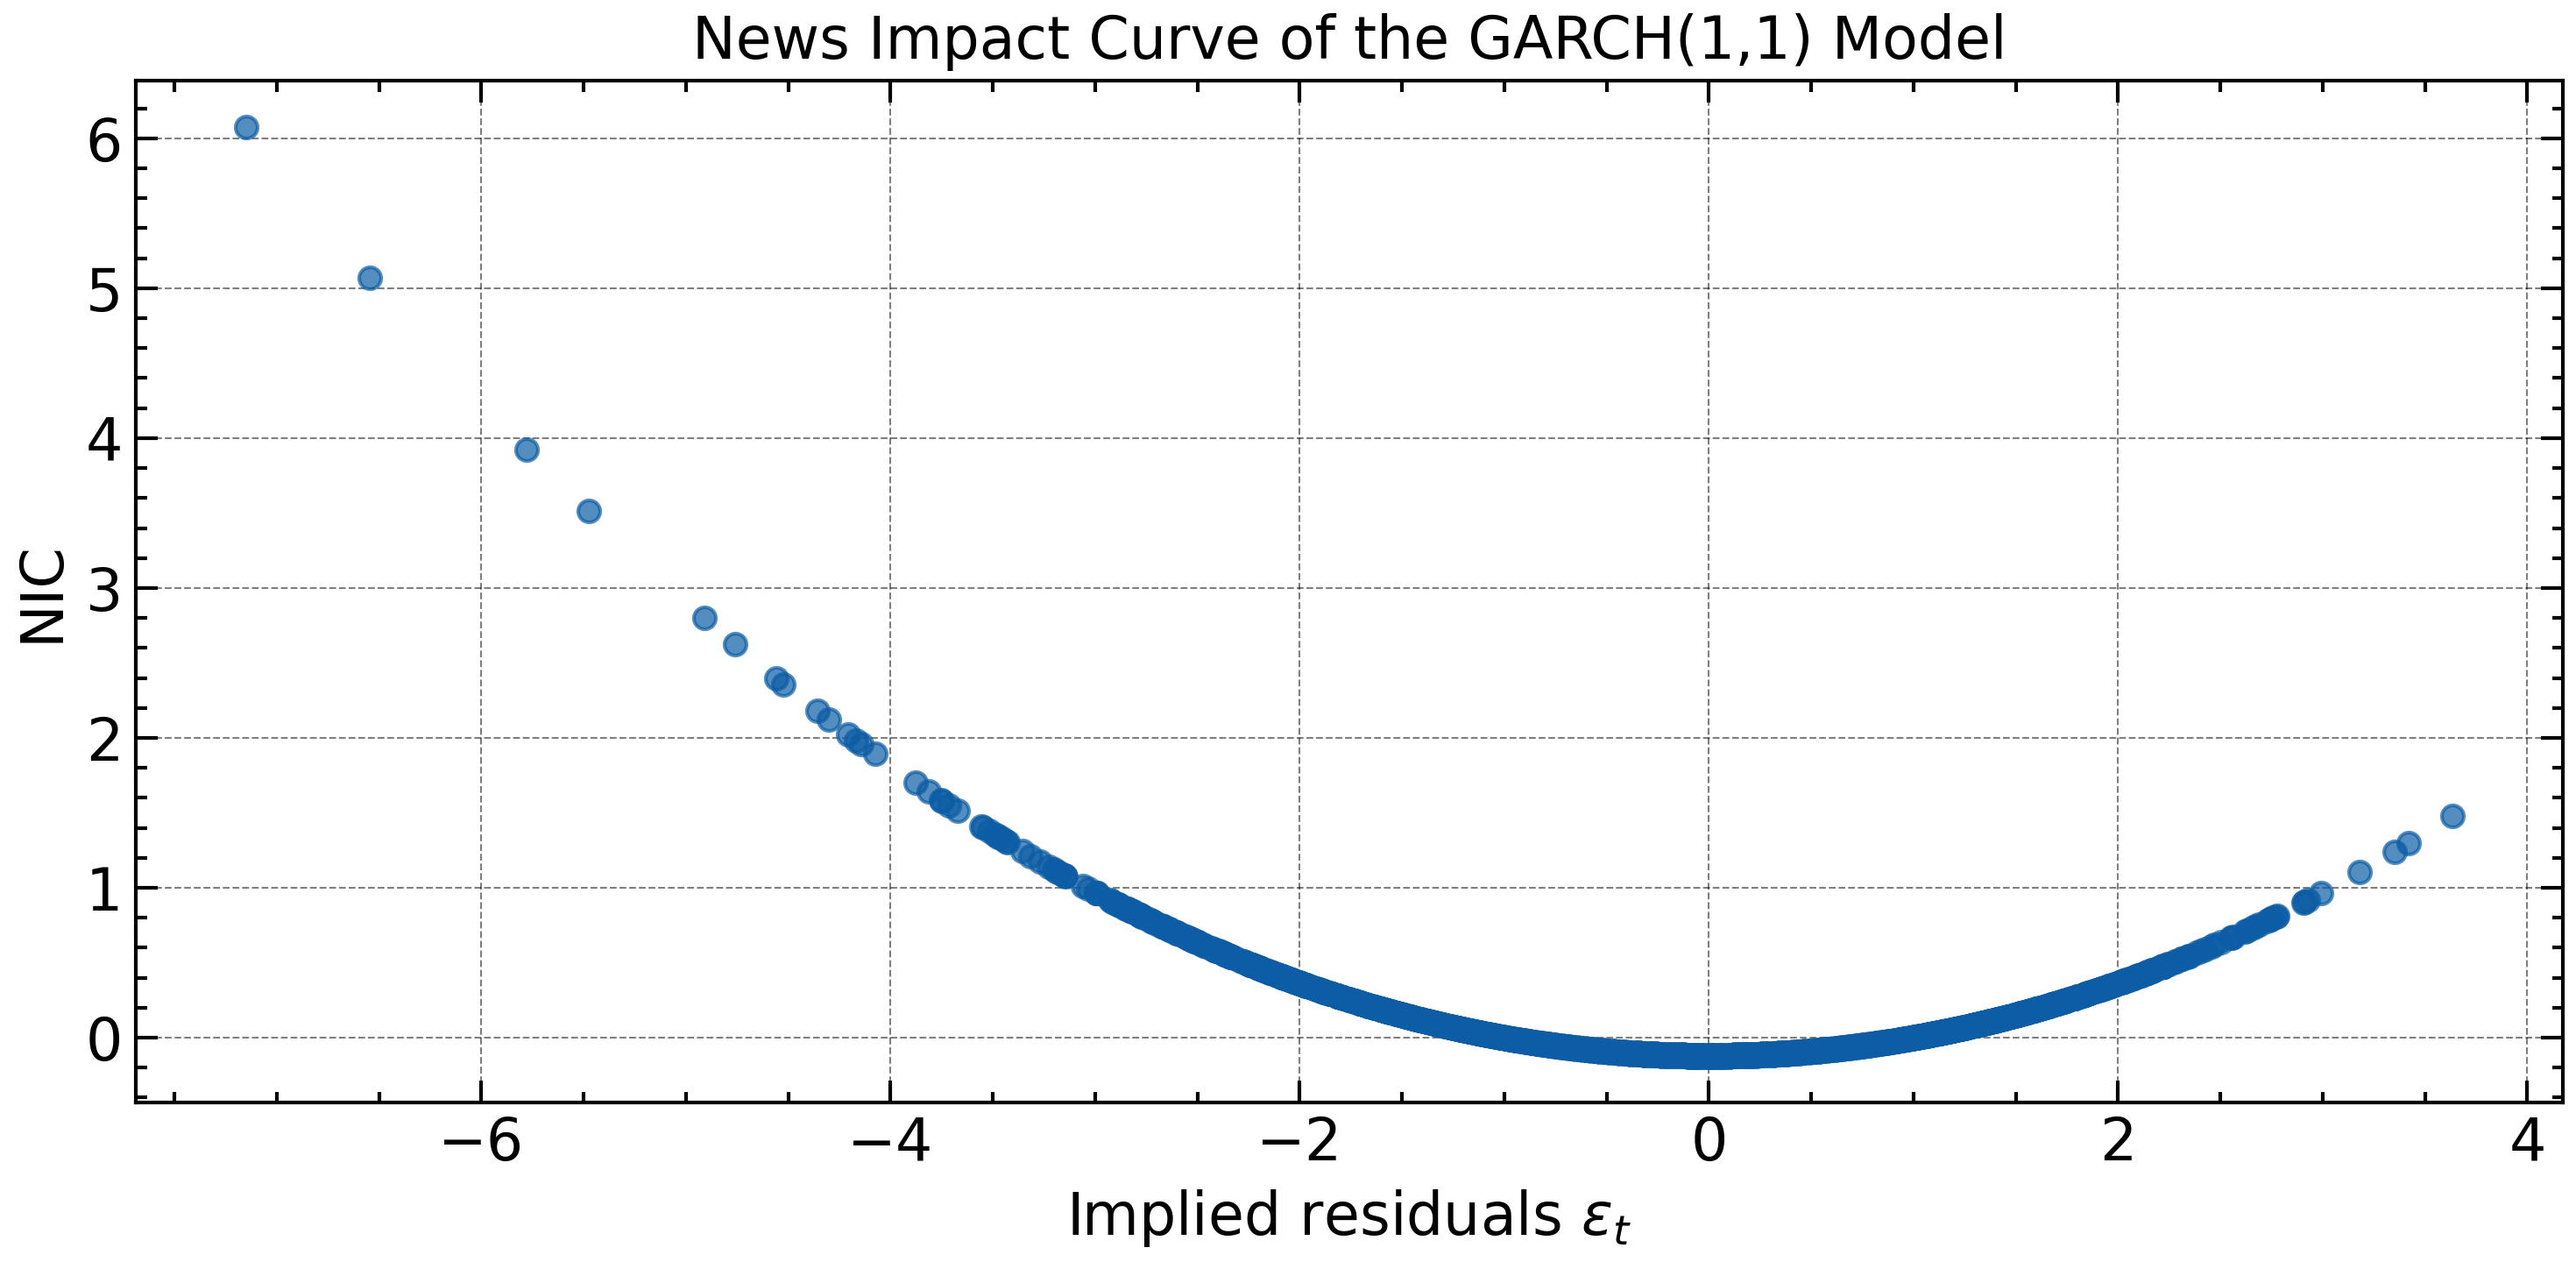

In [4]:
# Asymmetric GARCH
garch_model = GARCHModel('GARCH')
result = garch_model.fit(returns)

# Extract optimized parameters
mu_hat, omega_hat, alpha_hat, beta_hat, nu_hat = garch_model.parameters
log_likelihood = -result.fun
conditional_var = garch_model.garch(garch_model.parameters, returns)
plot_results(dates, returns, conditional_var, 'GARCH(1,1)')

print(f"Optimization Successful: {'Yes' if result.success else 'No'}")
print("Estimated Parameters:")
print(f"  mu    : {mu_hat:.3f}")
print(f"  omega : {omega_hat:.3f}")
print(f"  alpha : {alpha_hat:.3f}")
print(f"  beta  : {beta_hat:.3f}")
print(f"  nu    : {nu_hat:.3f}")
print(f"Log-Likelihood: {log_likelihood:.1f}")

epsilon = (returns - mu_hat) / np.sqrt(conditional_var)
nic = alpha_hat * (epsilon**2 * (epsilon >= 0) - 1/2) + alpha_hat * (epsilon**2 * (epsilon < 0) - 1/2)
plot_nic(epsilon, nic, 'GARCH(1,1) Model')

# Asymmetric GARCH

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:2: RuntimeWarning: divide by zero encountered in divide
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:2: RuntimeWarning: invalid value encountered in multiply
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:44: RuntimeWarning: invalid value encountered in sqrt
  epsilon = (returns - mu) / np.sqrt(sigma_squared + 1e-8)
/var/folders/4g/c51vp

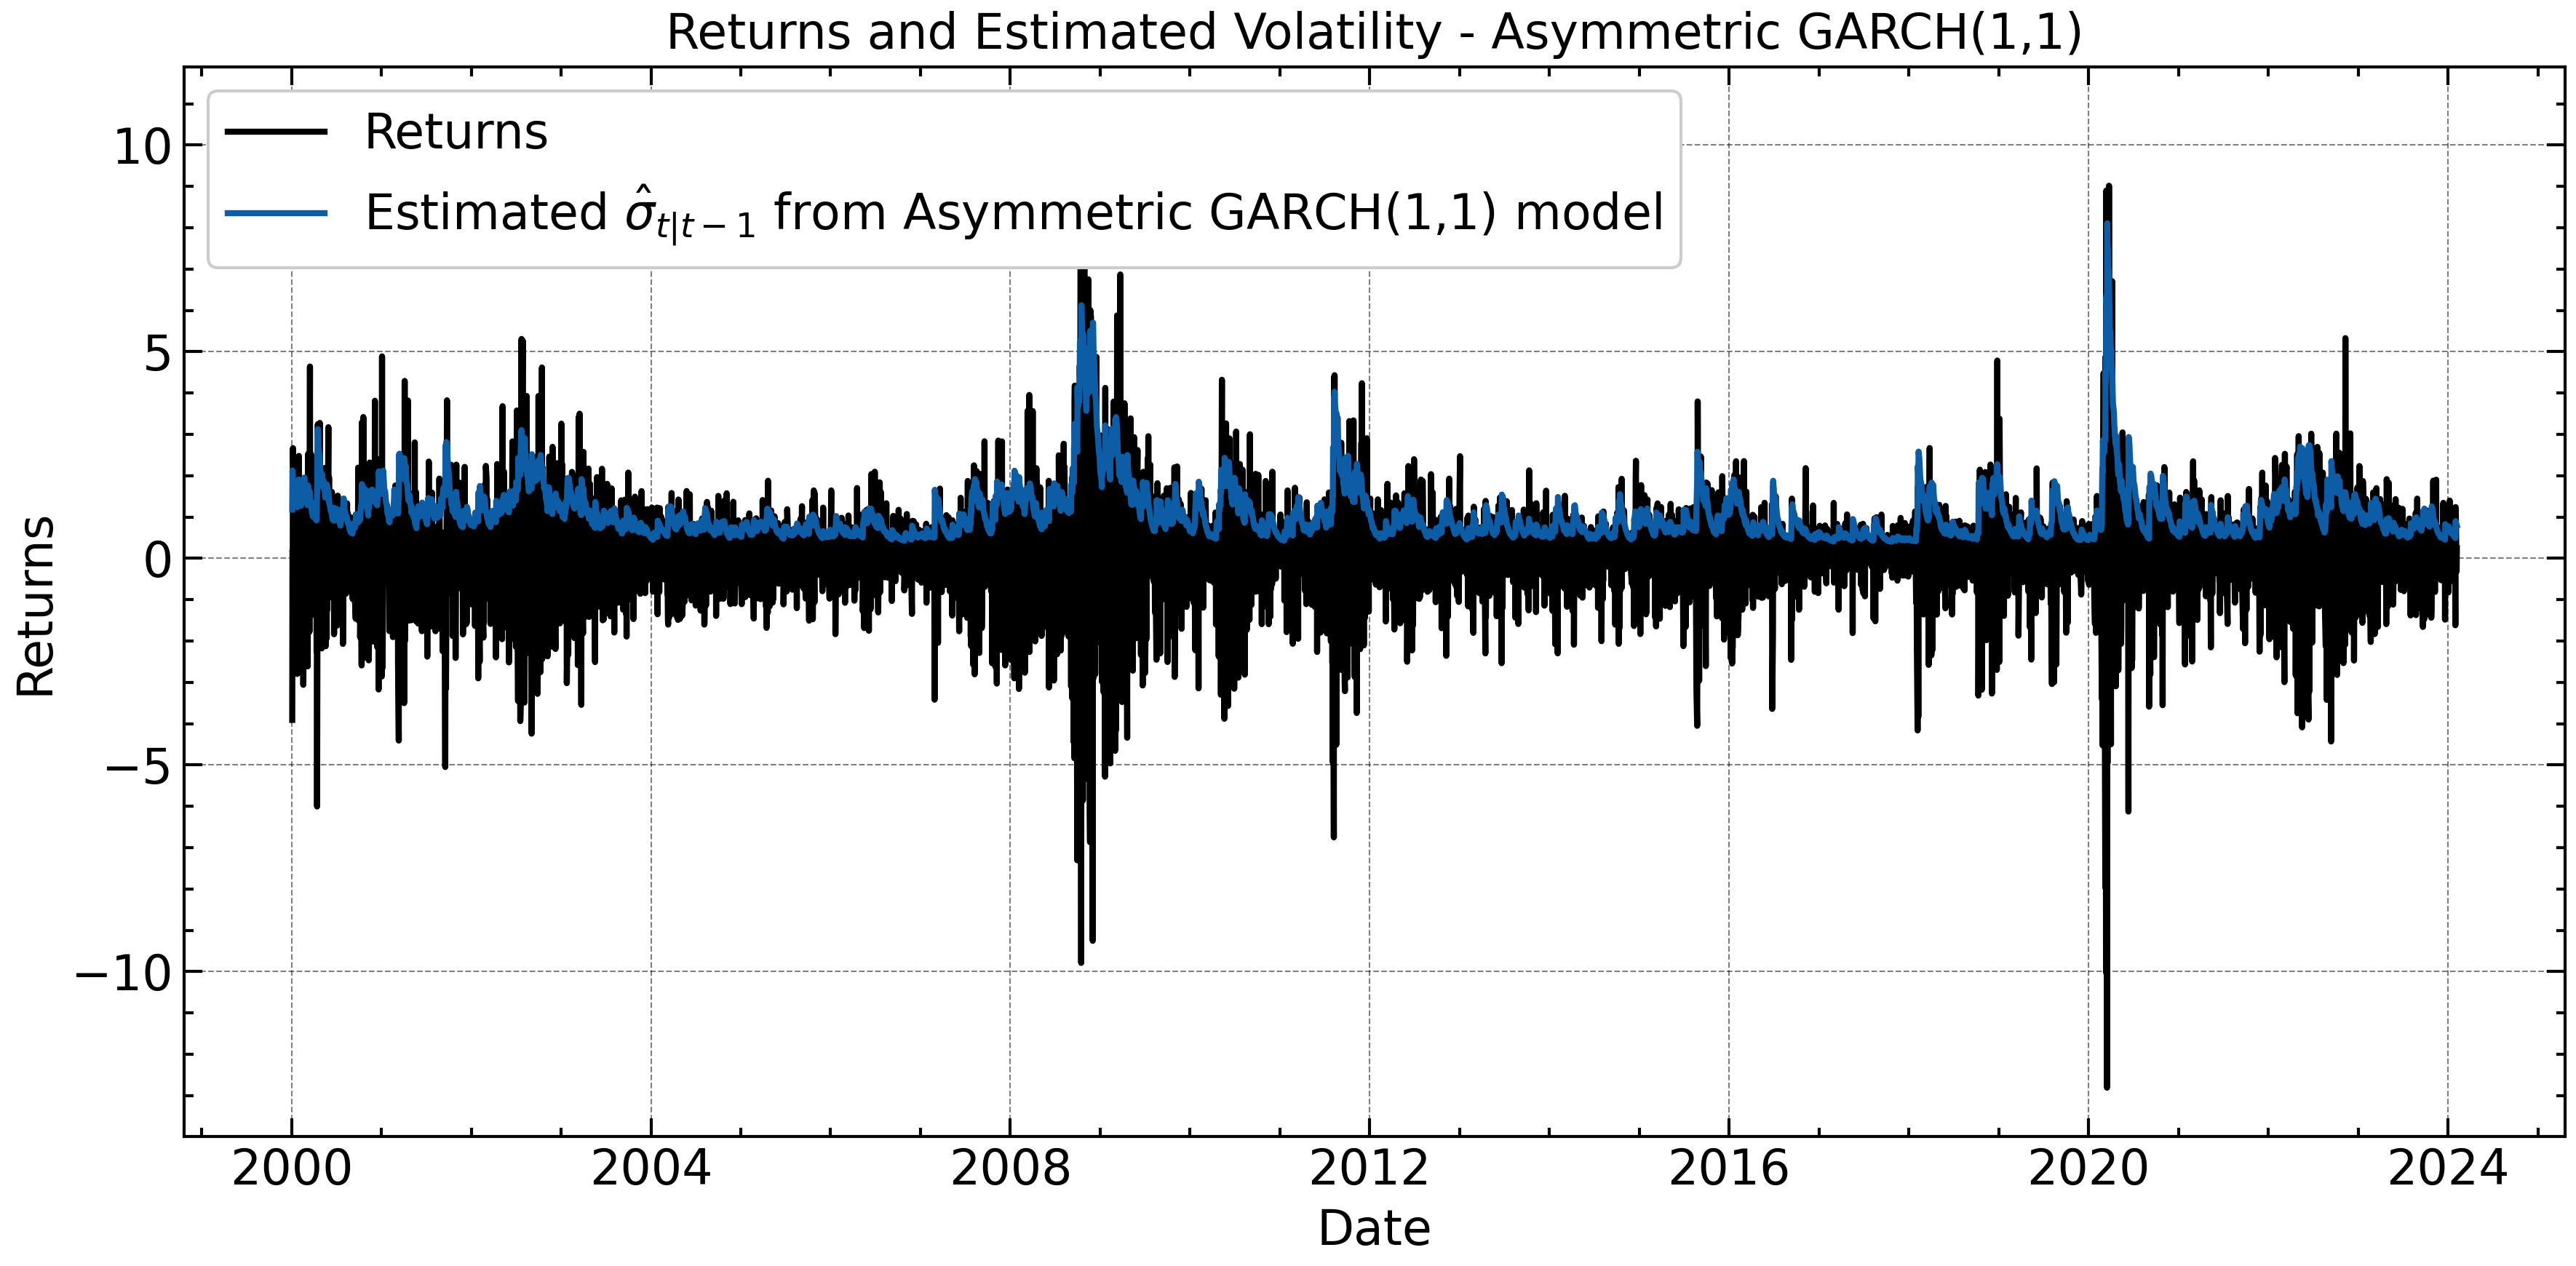

Optimization Successful: Yes
Estimated Parameters:
  mu          : 0.046
  omega       : 0.017
  alpha_pos   : 0.000
  alpha_neg   : 0.208
  beta        : 0.884
  nu          : 6.893
Log-Likelihood: -8111.4


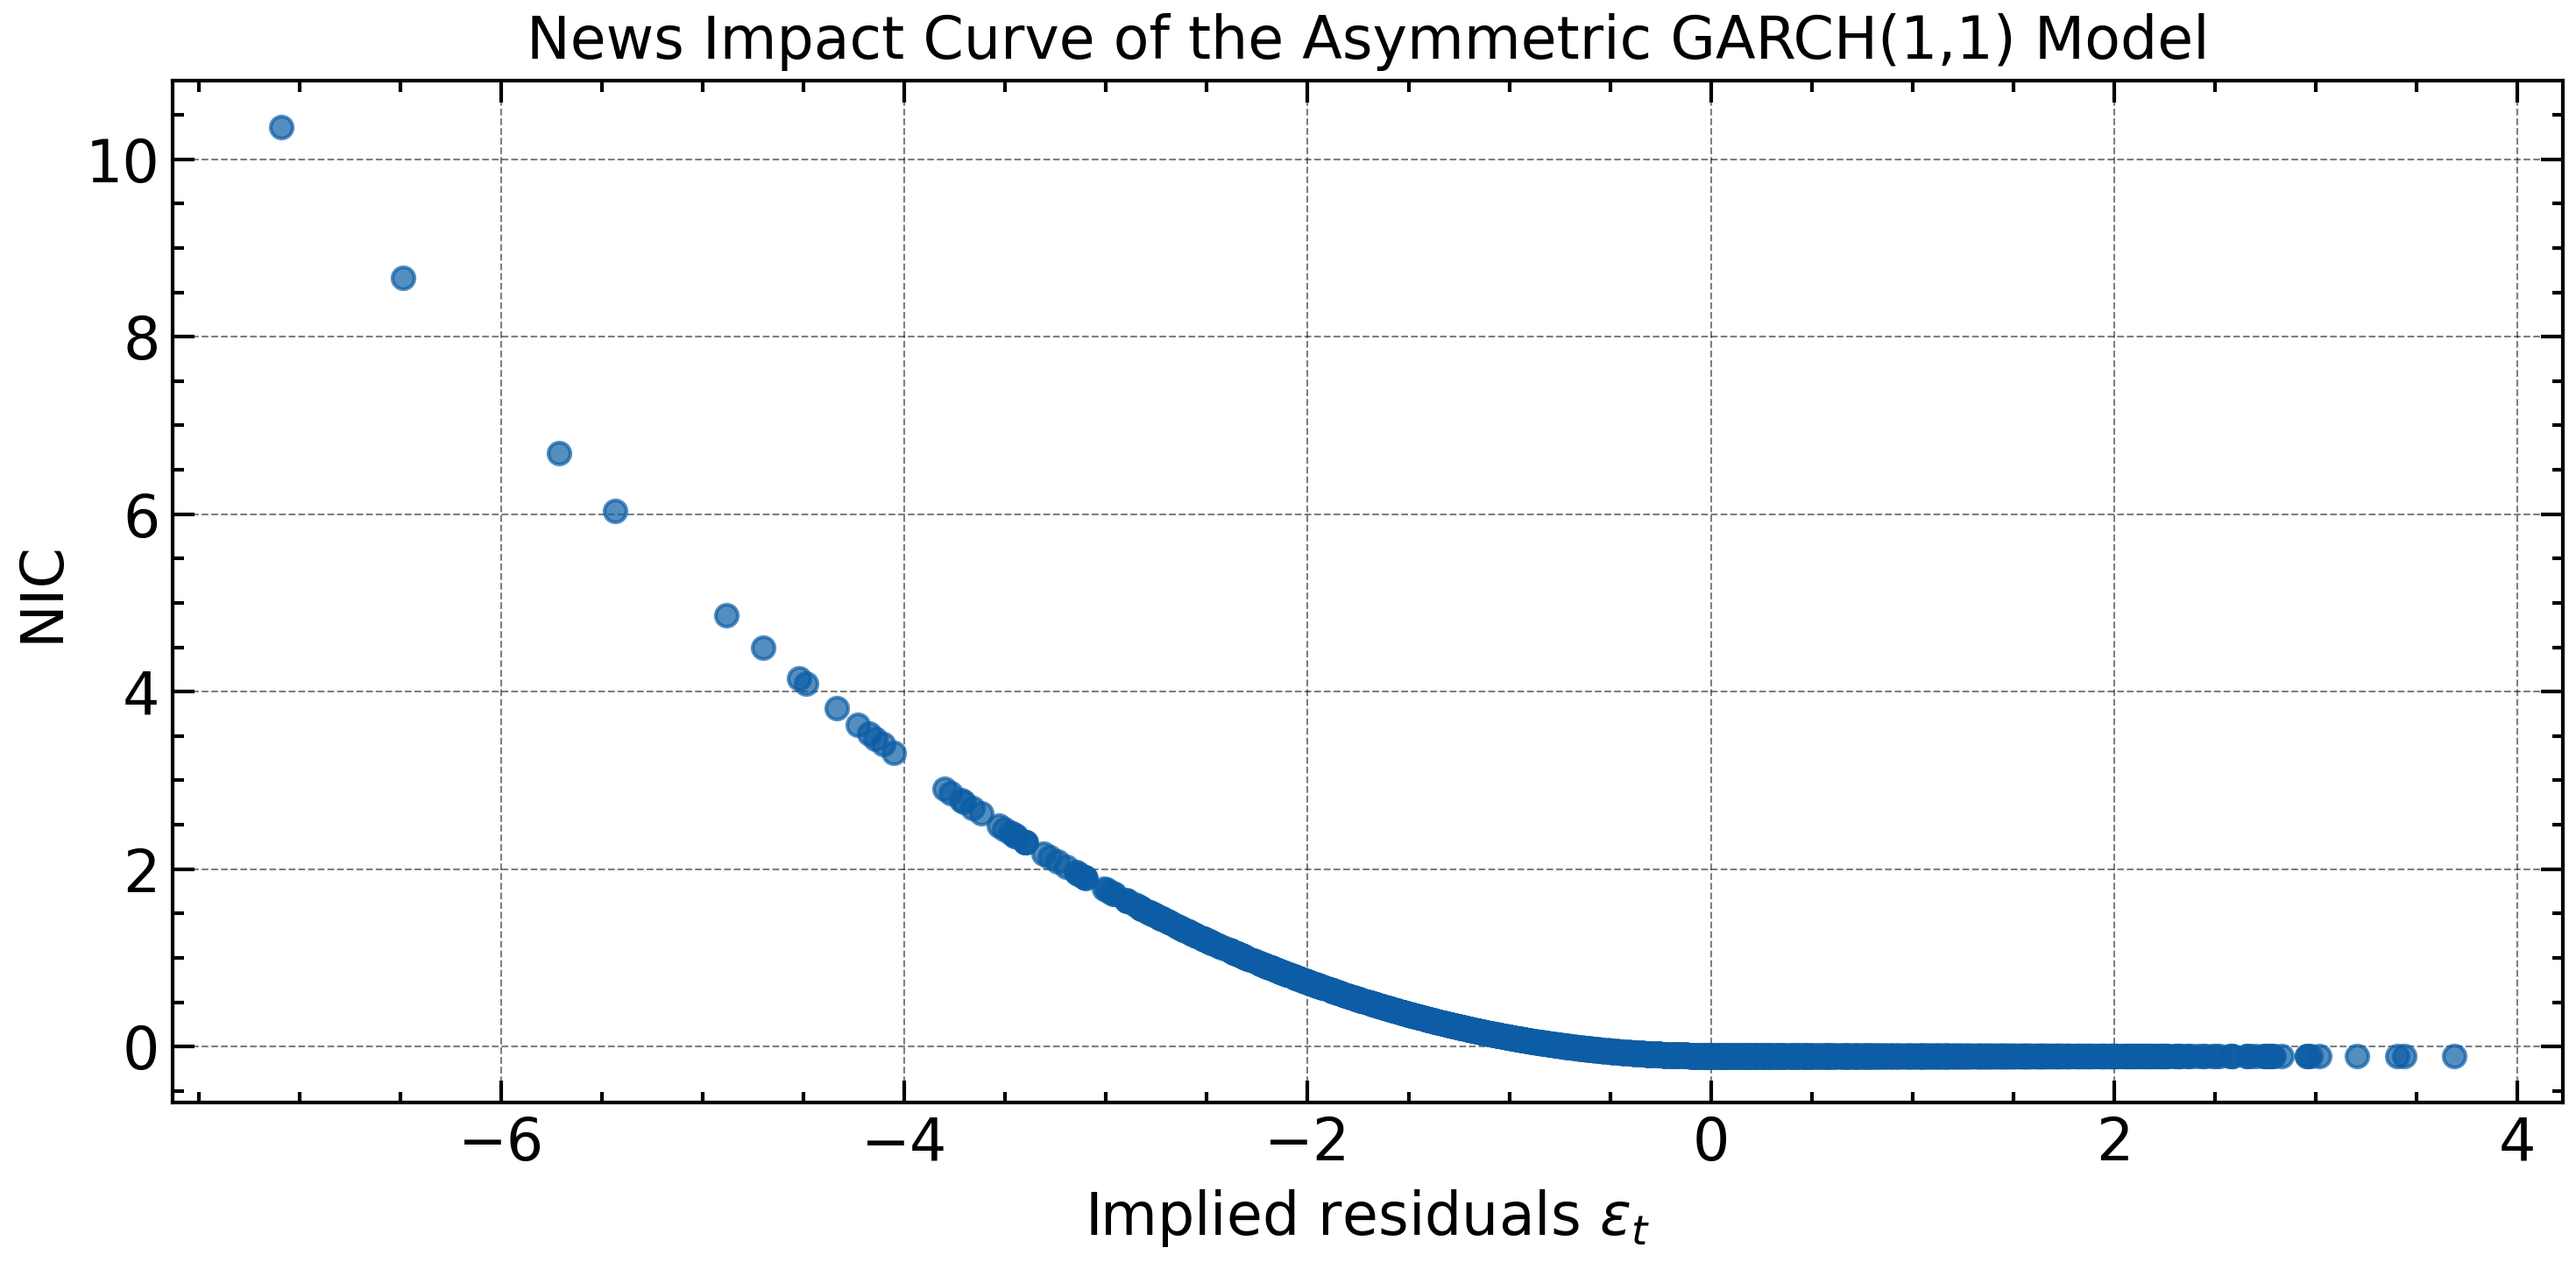

In [5]:
# Asymmetric GARCH
asymmetric_garch_model = GARCHModel('Asymmetric GARCH')
result = asymmetric_garch_model.fit(returns)

# Extract optimized parameters
mu_hat, omega_hat, alpha_hat_pos, alpha_hat_neg, beta_hat, nu_hat = result.x
log_likelihood = -result.fun
sigma_squared = asymmetric_garch_model.asymmetric_garch(result.x, returns)

plot_results(dates, returns, sigma_squared, 'Asymmetric GARCH(1,1)')

# Print results
print(f"Optimization Successful: {'Yes' if result.success else 'No'}")
print("Estimated Parameters:")
print(f"  mu          : {mu_hat:.3f}")
print(f"  omega       : {omega_hat:.3f}")
print(f"  alpha_pos   : {alpha_hat_pos:.3f}")
print(f"  alpha_neg   : {alpha_hat_neg:.3f}")
print(f"  beta        : {beta_hat:.3f}")
print(f"  nu          : {nu_hat:.3f}")
print(f"Log-Likelihood: {log_likelihood:.1f}")

epsilon = (returns - mu_hat) / np.sqrt(conditional_var)
nic = alpha_hat_pos * (epsilon**2 * (epsilon >= 0) - 1/2) + alpha_hat_neg * (epsilon**2 * (epsilon < 0) - 1/2)
plot_nic(epsilon, nic, 'Asymmetric GARCH(1,1) Model')

# Comparing Symmetric vs Asymmetric GARCH(1,1) models

In [6]:
# Estimate Parameters for Symmetric GARCH
garch_model = GARCHModel('GARCH')
result_symmetric = garch_model.fit(returns)
log_likelihood_symmetric = -result_symmetric.fun

# Estimate Parameters for Asymmetric GARCH
asymmetric_garch_model = GARCHModel('Asymmetric GARCH')
result_asymmetric = asymmetric_garch_model.fit(returns)
log_likelihood_asymmetric = -result_asymmetric.fun

# Compute Likelihood Ratio Statistic
LR_statistic = -2 * (log_likelihood_symmetric - log_likelihood_asymmetric)

# Degrees of freedom (difference in the number of parameters)
df = len(result_asymmetric.x) - len(result_symmetric.x)

# Compare with Chi-square Distribution
p_value = stats.chi2.sf(LR_statistic, df)

print("Likelihood Ratio Statistic:", LR_statistic)
print("Degrees of Freedom:", df)
print("P-value:", p_value)

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:2: RuntimeWarning: divide by zero encountered in divide
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:2: RuntimeWarning: invalid value encountered in multiply
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:44: RuntimeWarning: invalid value encountered in sqrt
  epsilon = (returns - mu) / np.sqrt(sigma_squared + 1e-8)
/var/folders/4g/c51vp

Likelihood Ratio Statistic: 199.71000589390678
Degrees of Freedom: 1
P-value: 2.416102341700114e-45


# Symmetric Beta-t-EGARCH

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:87: RuntimeWarning: overflow encountered in exp
  sigma[t] = np.exp(lambdas[t])
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:86: RuntimeWarning: overflow encountered in scalar multiply
  lambdas[t] = lam * (1 - phi) + phi * lambdas[t-1] + kappa * u[t-1] + kappa_tilde * v[t-1]
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:91: RuntimeWarning: overflow encountered in square
  return sigma**2, u, v
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:89: RuntimeWarning: overflow encountered in scalar power
  u[t] = np.sqrt((nu + 3) / (2 * nu)) * (((nu + 1) / (nu - 2 + epsilon[t]**2)) * epsilon[t]**2 - 1)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:89: RuntimeWarning: invalid value encountered in scalar multiply
  u[t] = np.sqrt((nu + 3) / (2 * nu)) * (((nu + 1) / (nu - 2 + epsilon[t]**2)) * 

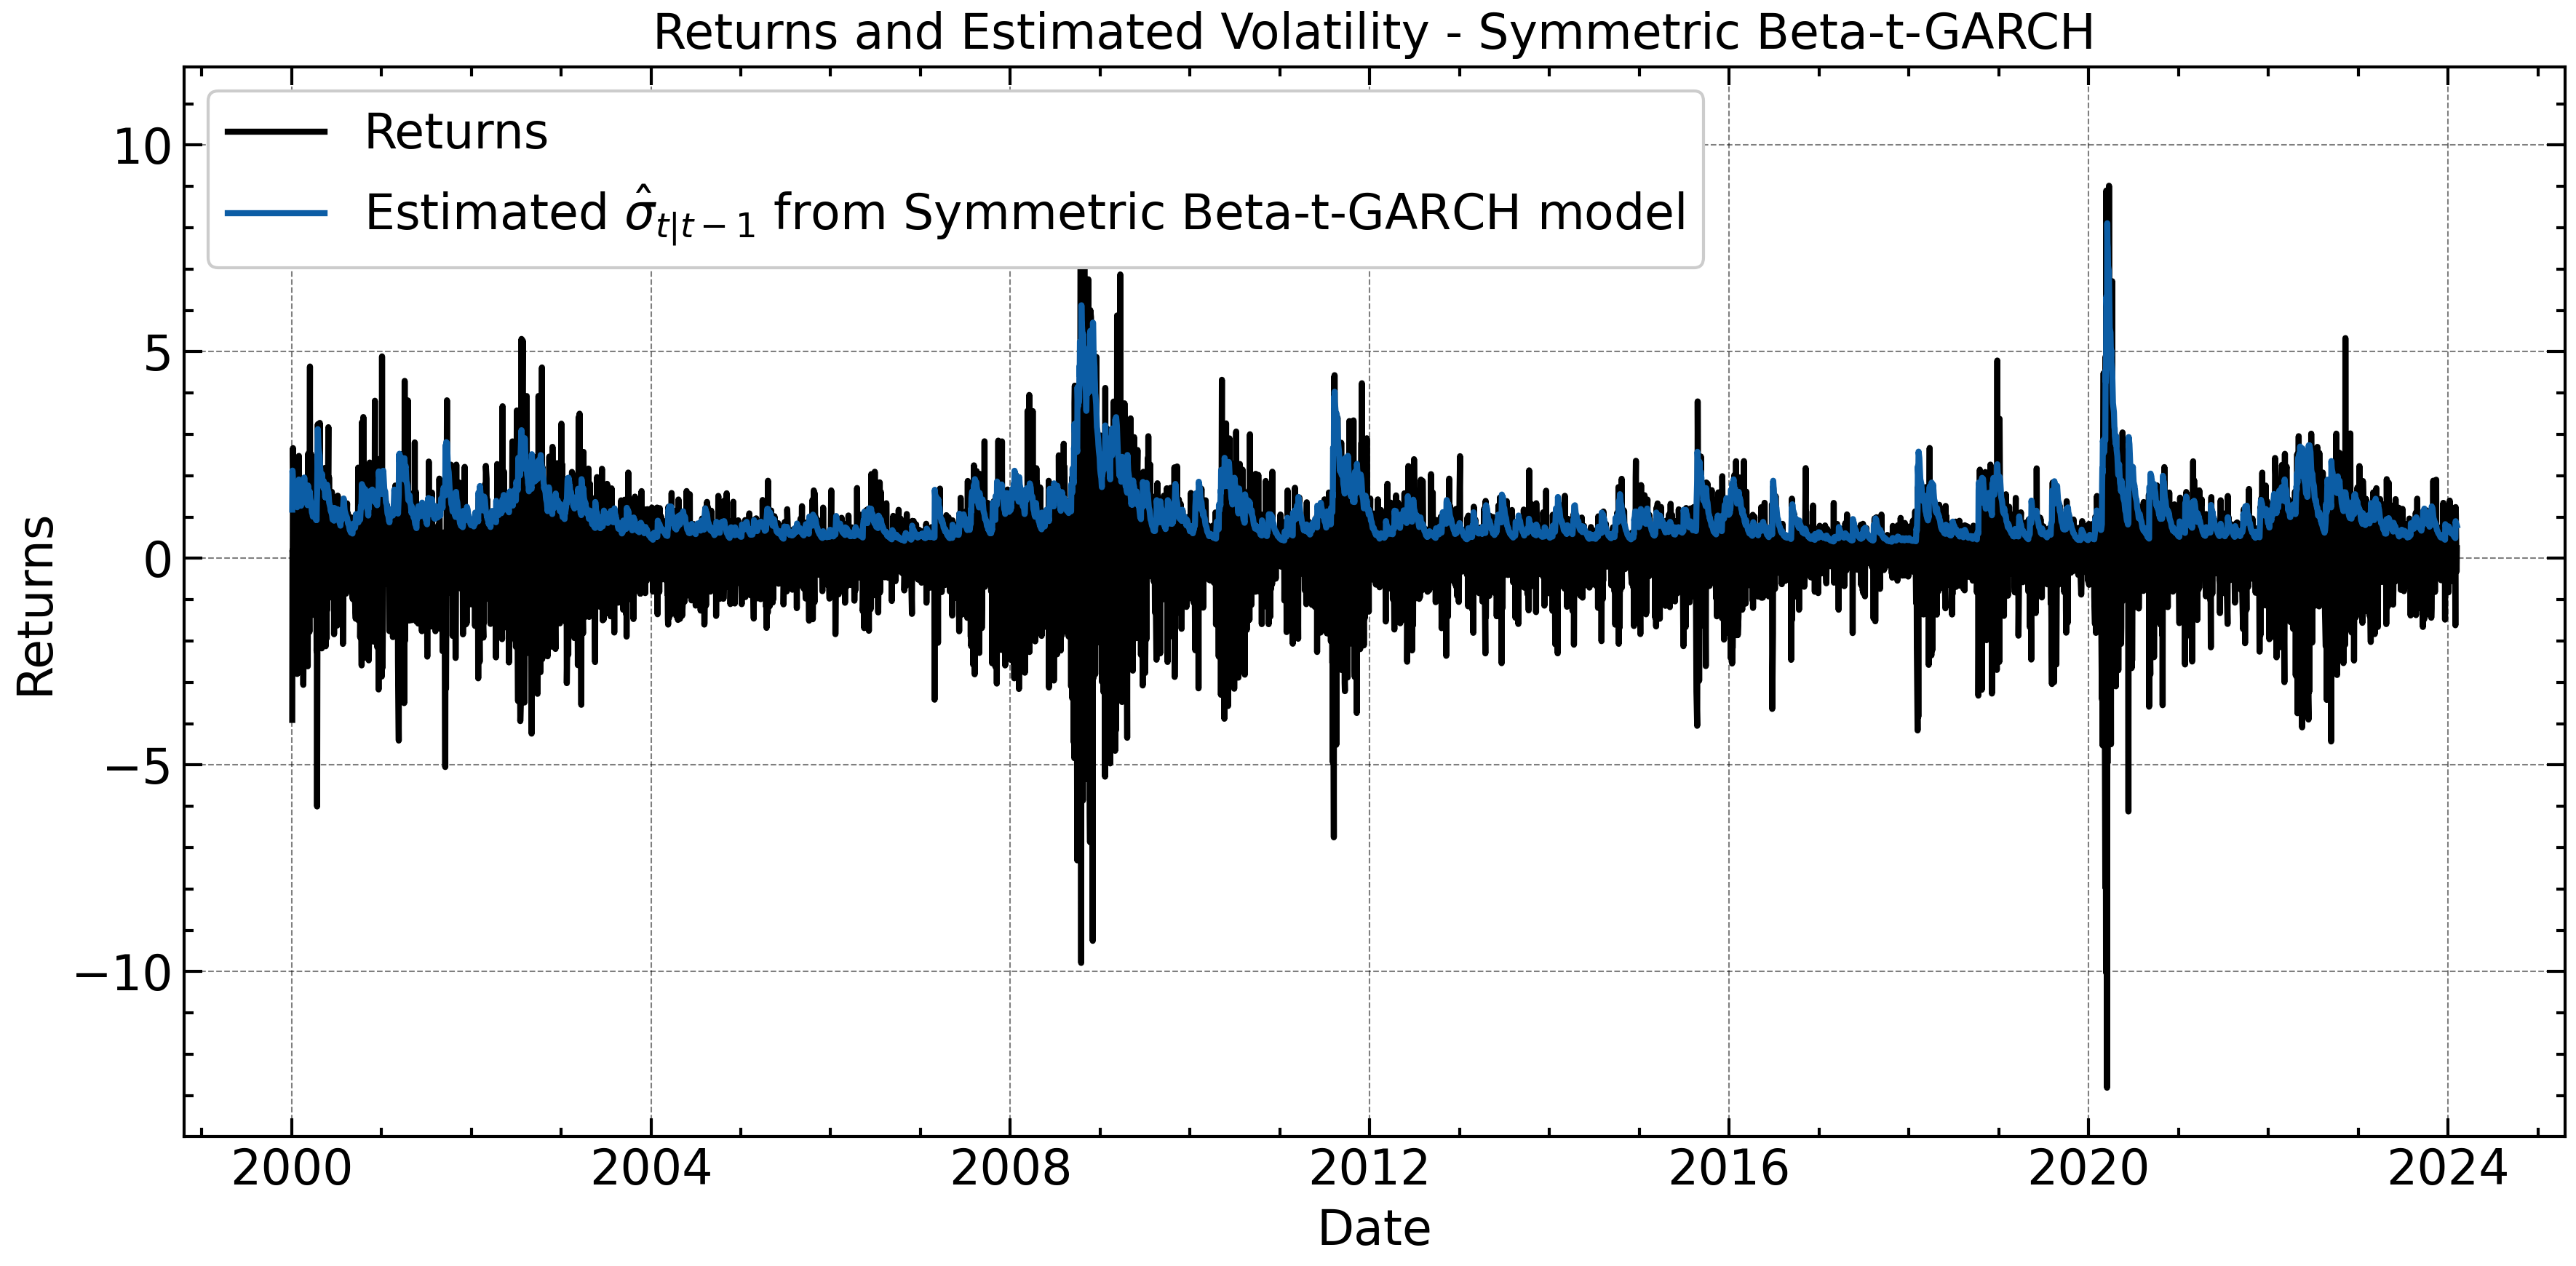

Optimization Successful: Yes
Estimated Parameters:
  mu     : 0.076
  lam    : 0.000
  phi    : 0.983
  kappa  : 0.080
  k_tilde: 0.000
  nu     : 7.178
Log-Likelihood: -8228.8


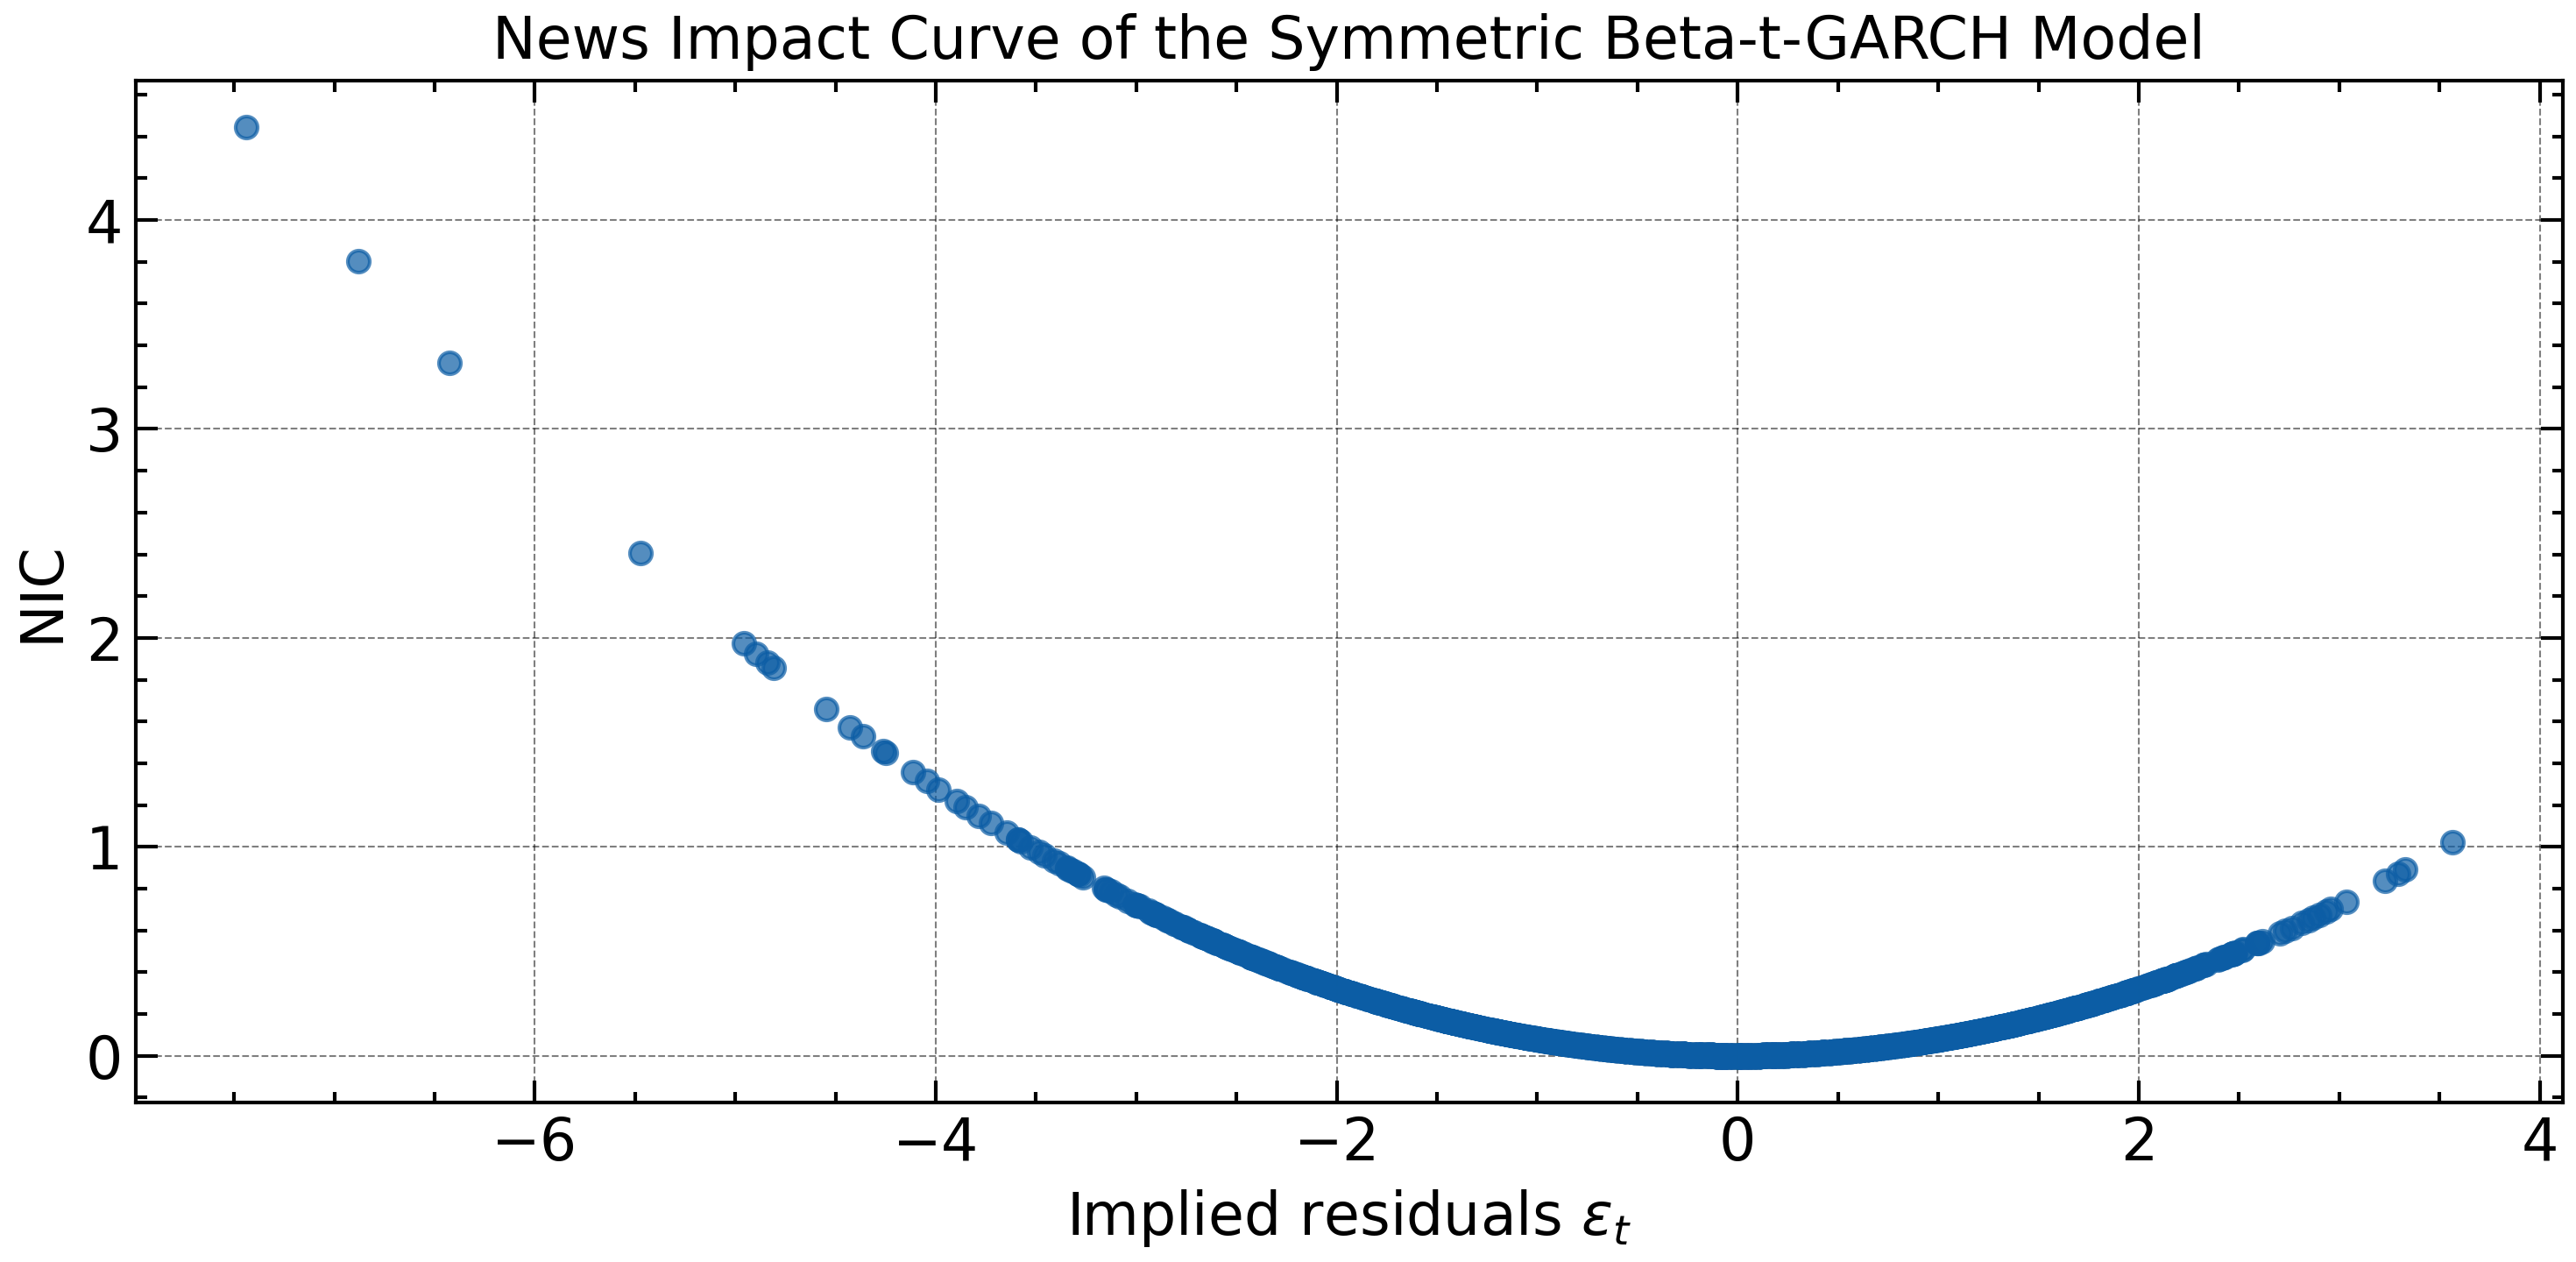

In [7]:
# Symmetric Beta-t-EGARCH
asymmetric_beta_t_egarch_model = GARCHModel('Symmetric Beta-t-EGARCH')
result = asymmetric_beta_t_egarch_model.fit(returns)

# Extract optimized parameters and plot results
mu_hat, lam_hat, phi_hat, kappa_hat, k_tilde_hat, nu_hat = result.x
log_likelihood = -result.fun
conditional_var, u, v = asymmetric_beta_t_egarch_model.asymmetric_beta_t_egarch(asymmetric_beta_t_egarch_model.parameters, returns)
plot_results(dates, returns, sigma_squared, 'Symmetric Beta-t-GARCH')

print(f"Optimization Successful: {'Yes' if result.success else 'No'}")
print("Estimated Parameters:")
print(f"  mu     : {mu_hat:.3f}")
print(f"  lam    : {lam_hat:.3f}")
print(f"  phi    : {phi_hat:.3f}")
print(f"  kappa  : {kappa_hat:.3f}")
print(f"  k_tilde: {k_tilde_hat:.3f}")
print(f"  nu     : {nu_hat:.3f}")
print(f"Log-Likelihood: {log_likelihood:.1f}")

epsilon = (returns - mu_hat) / np.sqrt(conditional_var)
nic = kappa_hat * (epsilon**2) + k_tilde_hat * epsilon
plot_nic(epsilon, nic, 'Symmetric Beta-t-GARCH Model')

# Asymmetric Beta-t-EGARCH

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:87: RuntimeWarning: overflow encountered in exp
  sigma[t] = np.exp(lambdas[t])
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:89: RuntimeWarning: divide by zero encountered in scalar divide
  u[t] = np.sqrt((nu + 3) / (2 * nu)) * (((nu + 1) / (nu - 2 + epsilon[t]**2)) * epsilon[t]**2 - 1)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:89: RuntimeWarning: invalid value encountered in scalar multiply
  u[t] = np.sqrt((nu + 3) / (2 * nu)) * (((nu + 1) / (nu - 2 + epsilon[t]**2)) * epsilon[t]**2 - 1)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:90: RuntimeWarning: divide by zero encountered in scalar divide
  v[t] = np.sqrt((nu + 2) * (nu + 3) / (nu + (nu + 1))) * ((nu + 1) / (nu - 2 + epsilon[t]**2)) * epsilon[t]
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:90: RuntimeWarning: invalid 

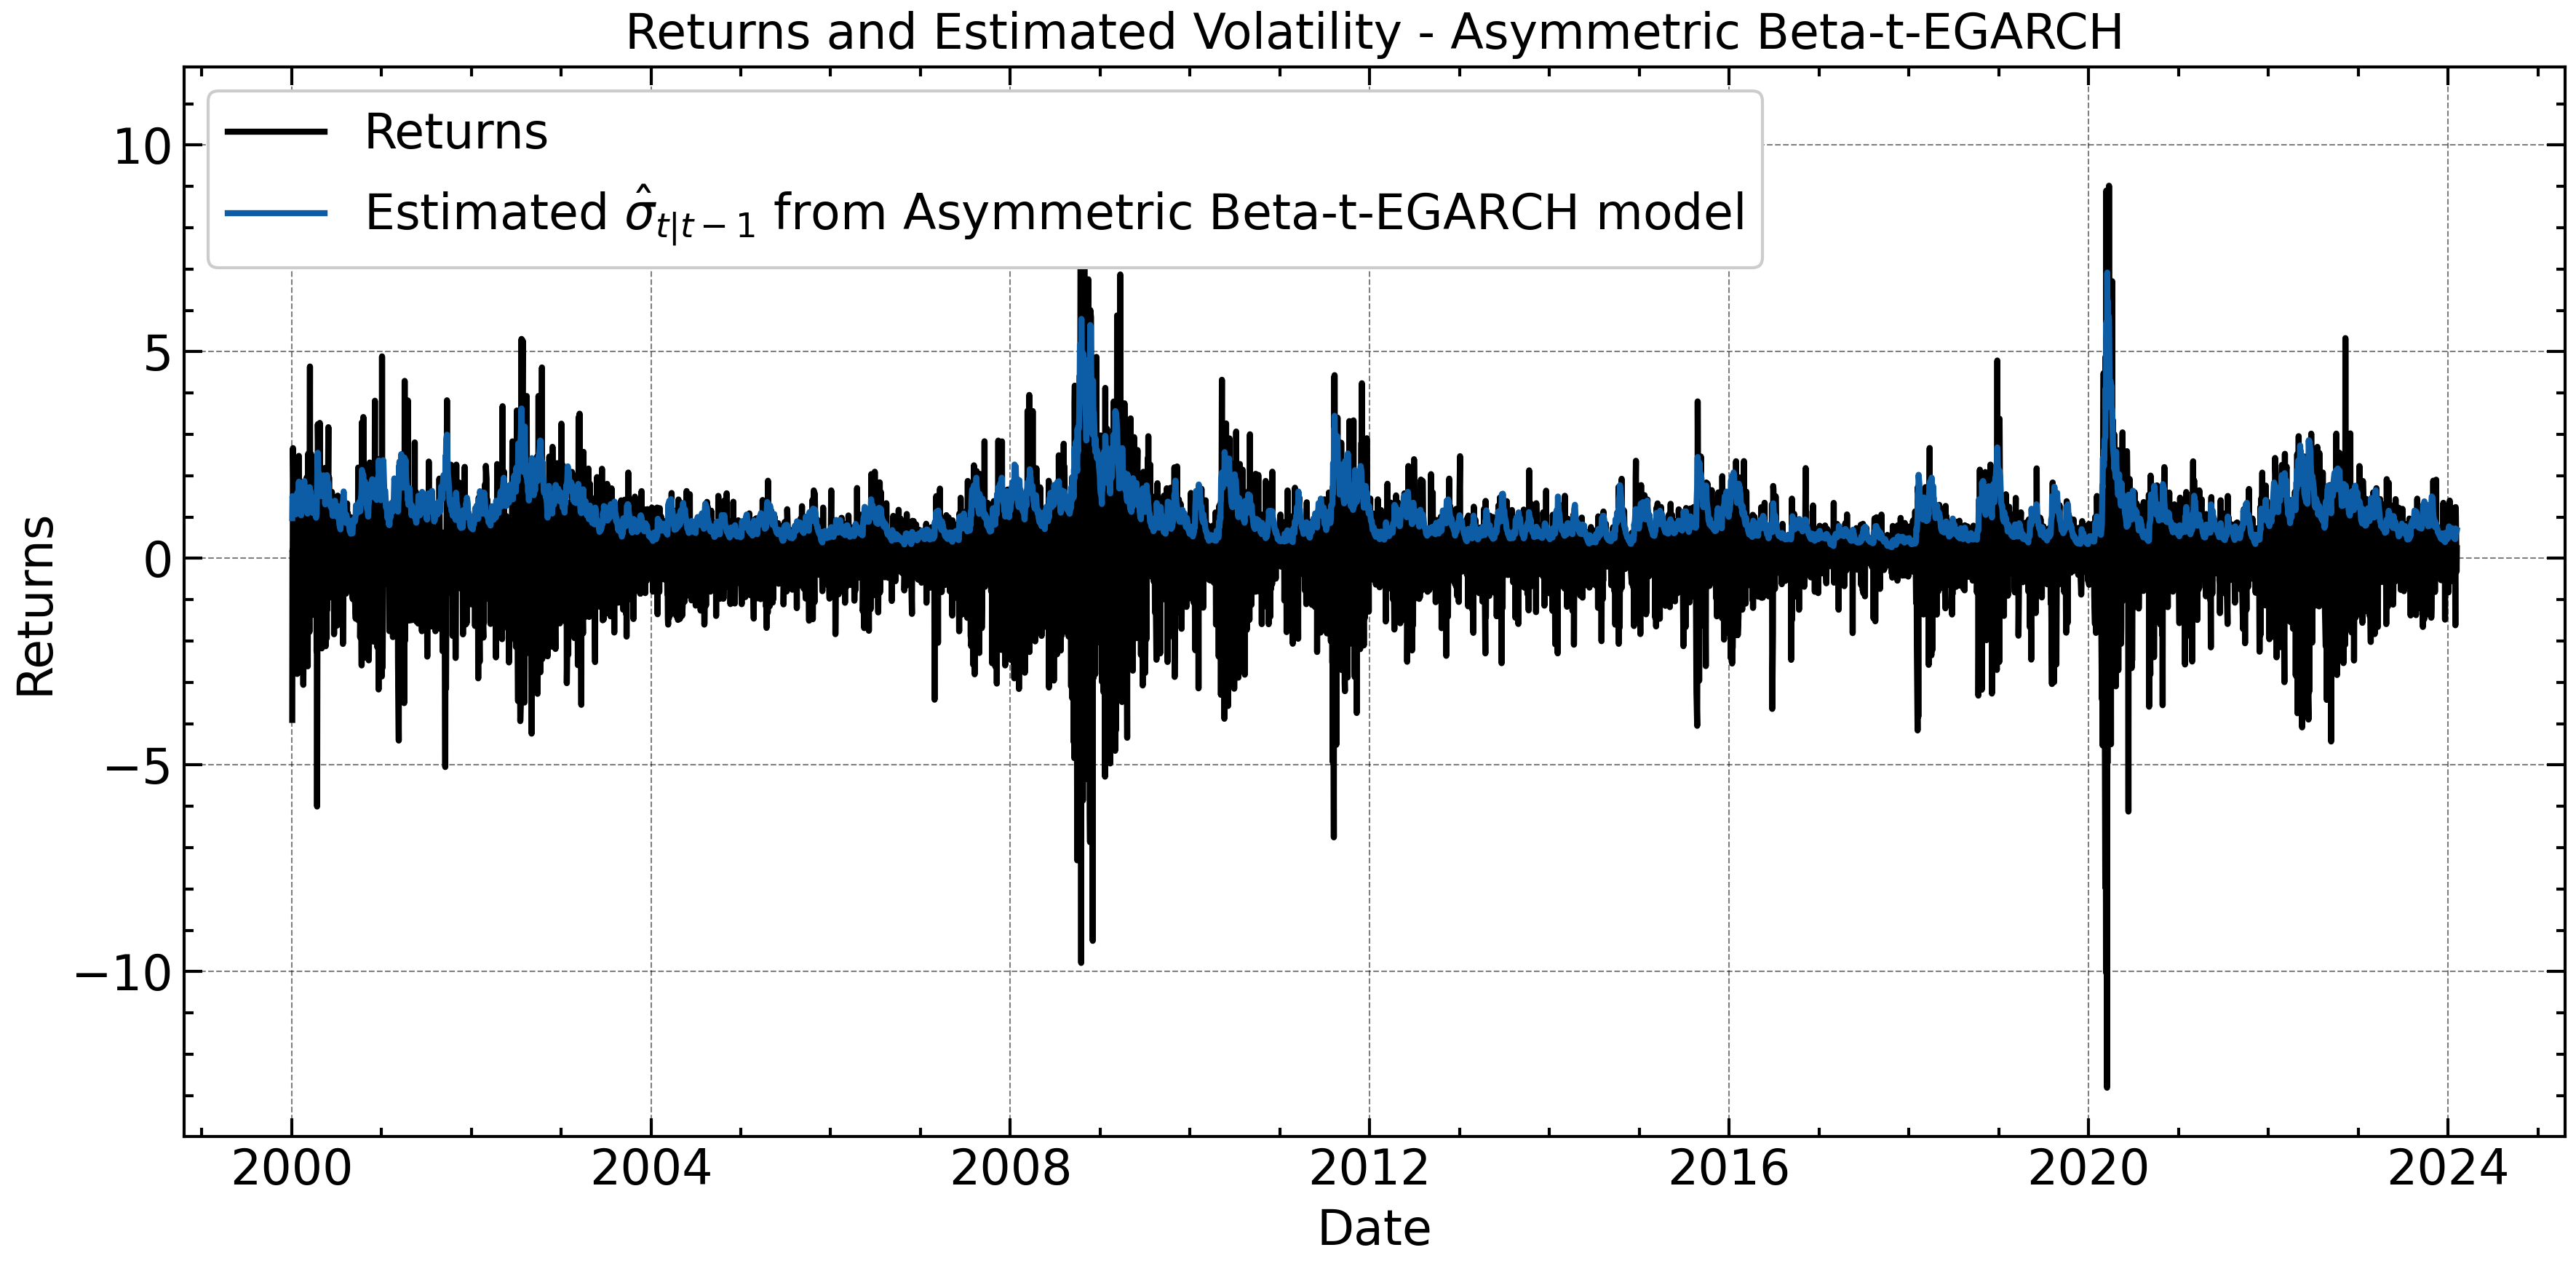

Optimization Successful: Yes
Estimated Parameters:
  mu     : 0.036
  lam    : -0.029
  phi    : 0.974
  kappa  : 0.061
  k_tilde: -0.034
  nu     : 8.497
Log-Likelihood: -8088.5


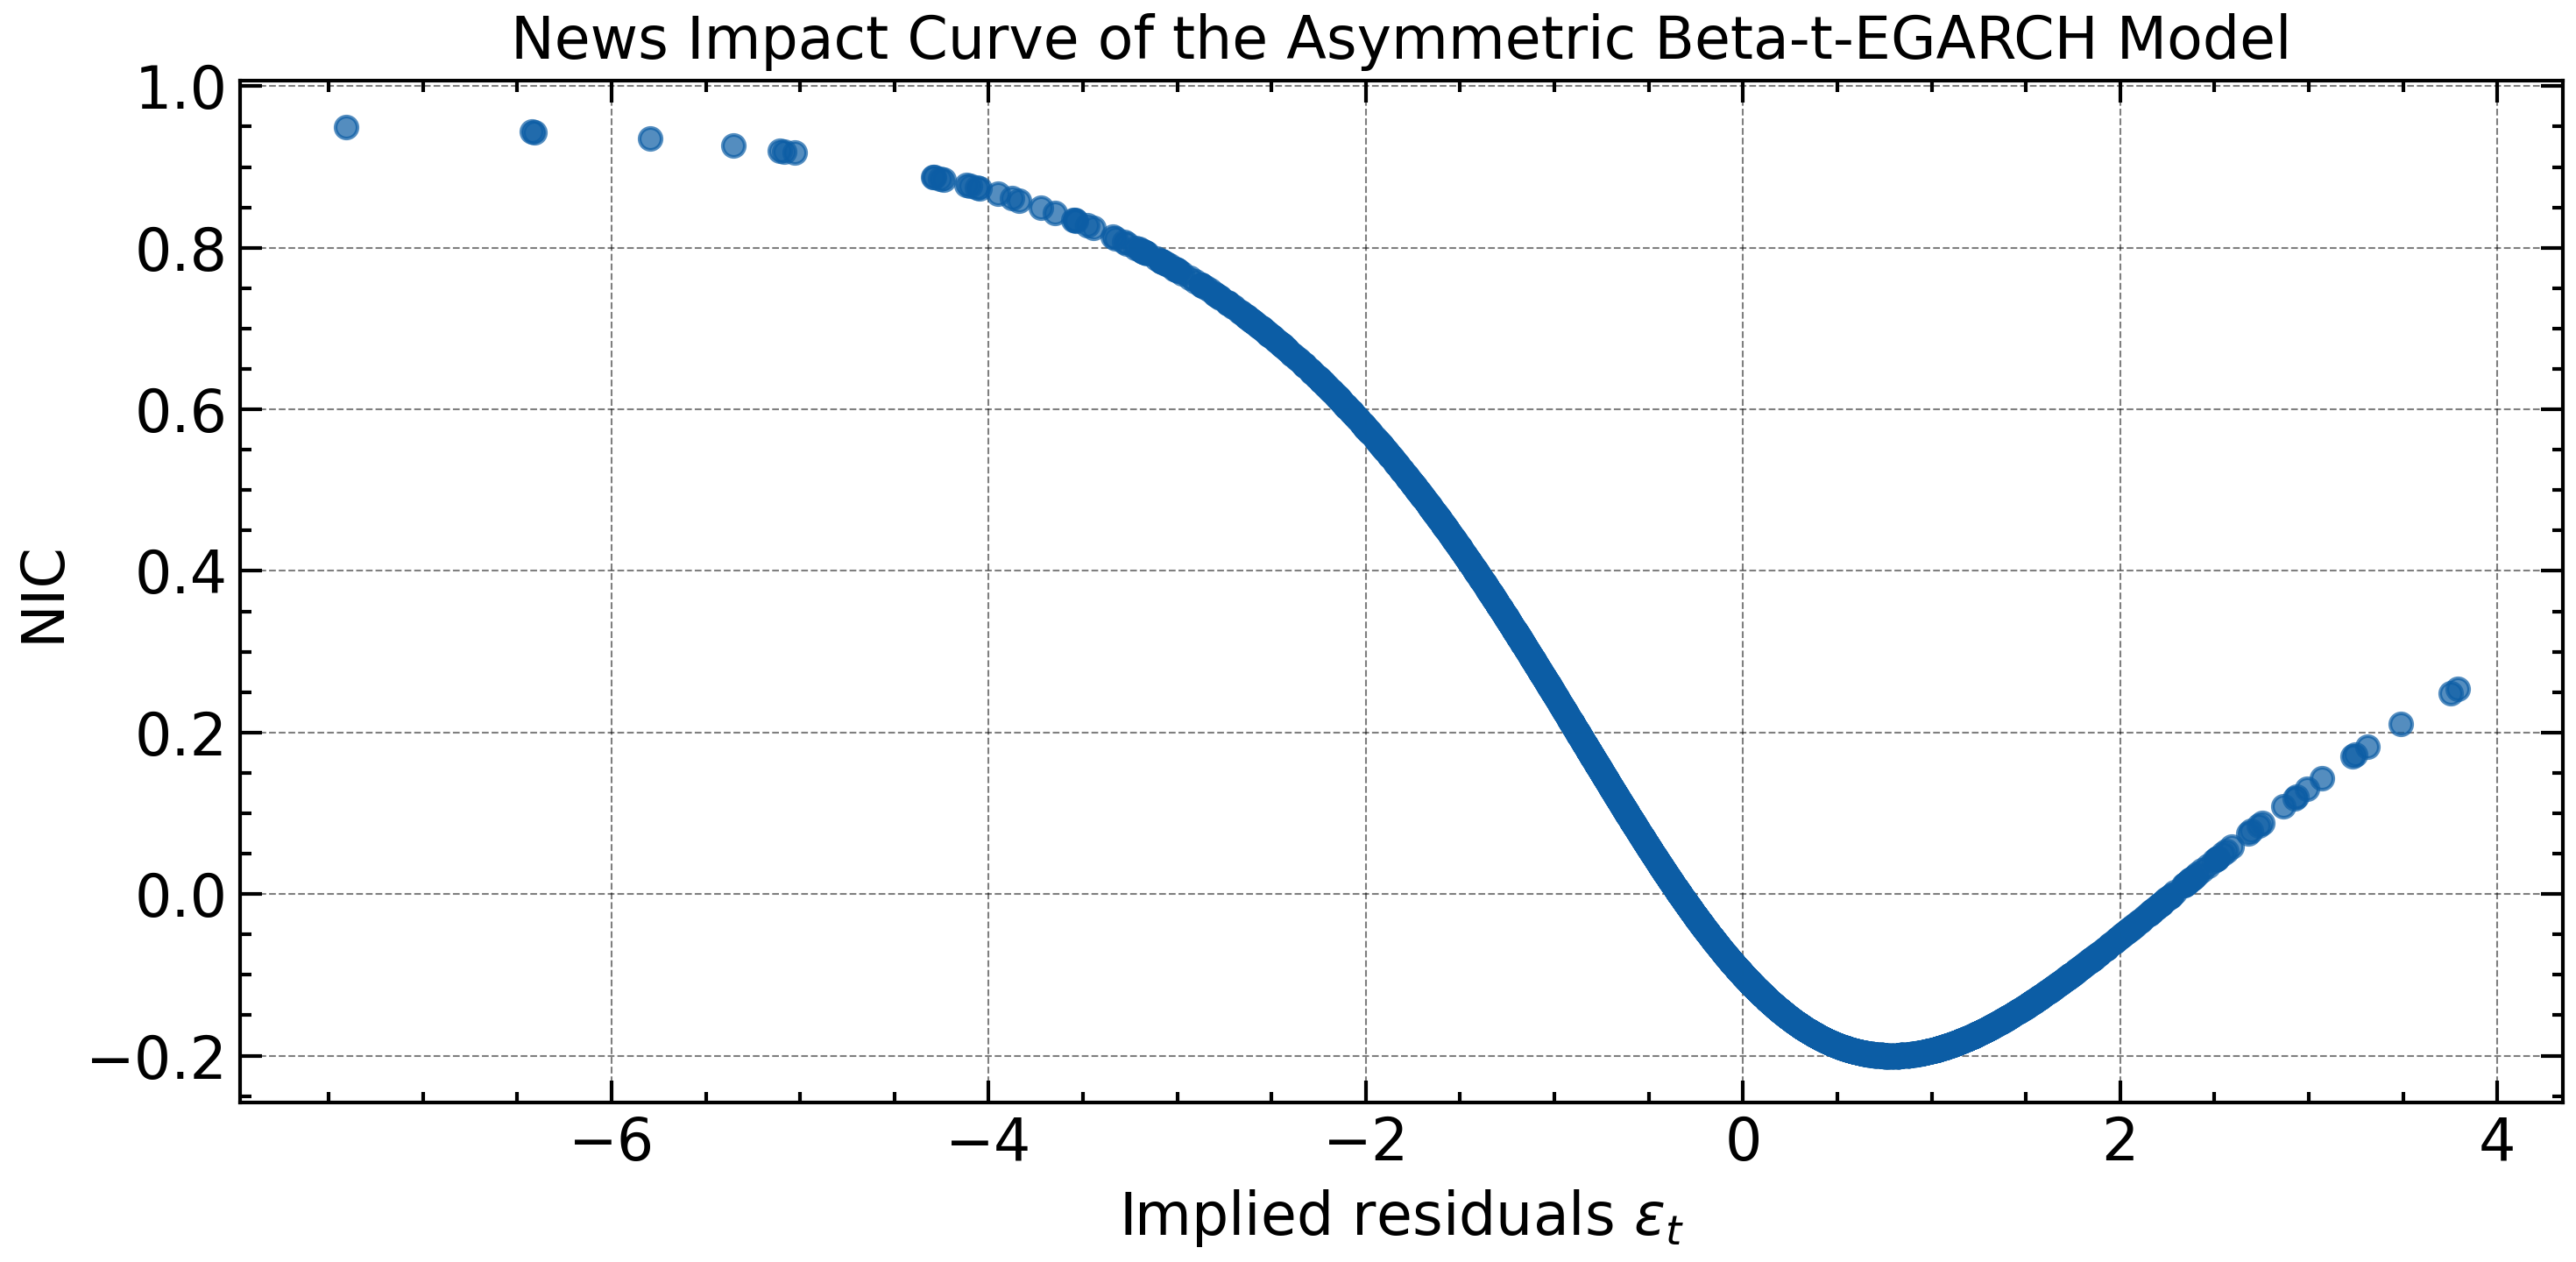

In [8]:
# Asymmetric Beta-t-EGARCH
asymmetric_beta_t_egarch_model = GARCHModel('Asymmetric Beta-t-EGARCH')
result = asymmetric_beta_t_egarch_model.fit(returns)

# Extract optimized parameters and plot results
mu_hat, lam_hat, phi_hat, kappa_hat, k_tilde_hat, nu_hat = result.x
log_likelihood = -result.fun
conditional_var, u, v = asymmetric_beta_t_egarch_model.asymmetric_beta_t_egarch(asymmetric_beta_t_egarch_model.parameters, returns)
plot_results(dates, returns, conditional_var, 'Asymmetric Beta-t-EGARCH')

print(f"Optimization Successful: {'Yes' if result.success else 'No'}")
print("Estimated Parameters:")
print(f"  mu     : {mu_hat:.3f}")
print(f"  lam    : {lam_hat:.3f}")
print(f"  phi    : {phi_hat:.3f}")
print(f"  kappa  : {kappa_hat:.3f}")
print(f"  k_tilde: {k_tilde_hat:.3f}")
print(f"  nu     : {nu_hat:.3f}")
print(f"Log-Likelihood: {log_likelihood:.1f}")

nic = 2 * kappa_hat * u + 2 * k_tilde_hat * v
plot_nic((returns - mu_hat) / np.sqrt(conditional_var), nic, 'Asymmetric Beta-t-EGARCH Model')

# Comparing Symmetric vs Asymmetric Beta-t-EGARCH models

In [9]:
# Estimate Parameters for Symmetric GARCH
garch_model = GARCHModel('Symmetric Beta-t-EGARCH')
result_symmetric = garch_model.fit(returns)
log_likelihood_symmetric = -result_symmetric.fun

# Estimate Parameters for Asymmetric GARCH
asymmetric_garch_model = GARCHModel('Asymmetric Beta-t-EGARCH')
result_asymmetric = asymmetric_garch_model.fit(returns)
log_likelihood_asymmetric = -result_asymmetric.fun

# Compute Likelihood Ratio Statistic
LR_statistic = -2 * (log_likelihood_symmetric - log_likelihood_asymmetric)

df = 1

# Compare with Chi-square Distribution
p_value = stats.chi2.sf(LR_statistic, df)

print("Likelihood Ratio Statistic:", LR_statistic)
print("Degrees of Freedom:", df)
print("P-value:", p_value)

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:87: RuntimeWarning: overflow encountered in exp
  sigma[t] = np.exp(lambdas[t])
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:86: RuntimeWarning: overflow encountered in scalar multiply
  lambdas[t] = lam * (1 - phi) + phi * lambdas[t-1] + kappa * u[t-1] + kappa_tilde * v[t-1]
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:91: RuntimeWarning: overflow encountered in square
  return sigma**2, u, v
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:89: RuntimeWarning: overflow encountered in scalar power
  u[t] = np.sqrt((nu + 3) / (2 * nu)) * (((nu + 1) / (nu - 2 + epsilon[t]**2)) * epsilon[t]**2 - 1)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:89: RuntimeWarning: invalid value encountered in scalar multiply
  u[t] = np.sqrt((nu + 3) / (2 * nu)) * (((nu + 1) / (nu - 2 + epsilon[t]**2)) * 

Likelihood Ratio Statistic: 280.48717484513327
Degrees of Freedom: 1
P-value: 5.880748732544633e-63


# Compare News Impact Curves

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:2: RuntimeWarning: divide by zero encountered in divide
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:2: RuntimeWarning: invalid value encountered in multiply
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:44: RuntimeWarning: invalid value encountered in sqrt
  epsilon = (returns - mu) / np.sqrt(sigma_squared + 1e-8)
/var/folders/4g/c51vp

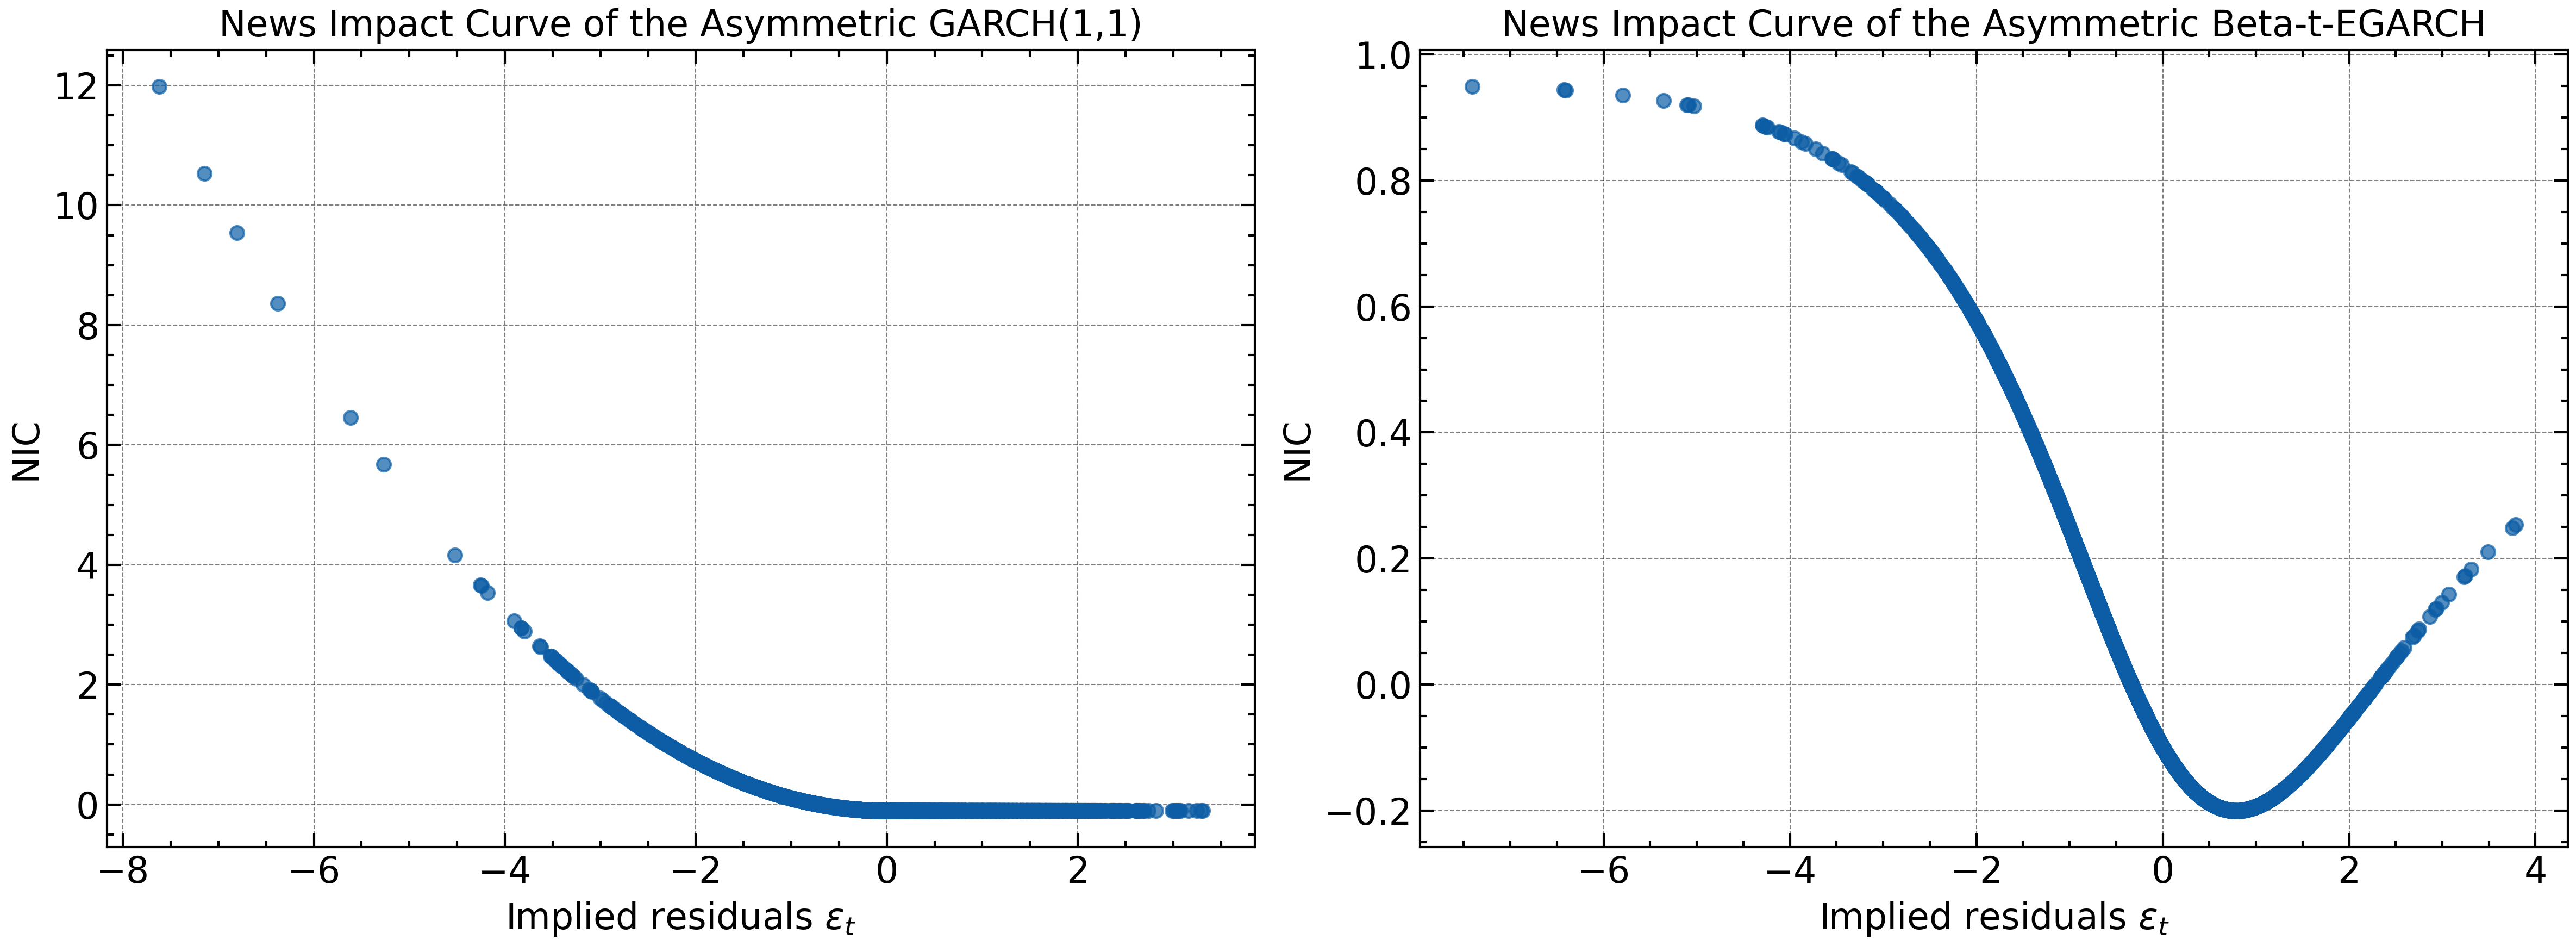

In [10]:
def plot_nic_subplot(epsilon, nic, model_name, ax):
    ax.scatter(epsilon, nic, alpha=0.7)
    ax.set_xlabel('Implied residuals $\epsilon_t$')
    ax.set_ylabel('NIC')
    ax.set_title(f'News Impact Curve of the {model_name}')
    ax.grid(True)

# Plot NIC for both models
fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=300)

# Asymmetric GARCH Model
asymmetric_garch_model = GARCHModel('Asymmetric GARCH')
result = asymmetric_garch_model.fit(returns)

# Extract optimized parameters and compute NIC
mu_hat, omega_hat, alpha_hat_pos, alpha_hat_neg, beta_hat, nu_hat = asymmetric_garch_model.parameters
conditional_var = asymmetric_garch_model.asymmetric_garch(asymmetric_garch_model.parameters, returns)
epsilon = (returns - mu_hat) / np.sqrt(conditional_var)
nic_asymmetric_garch_values = alpha_hat_pos * (epsilon**2 * (epsilon >= 0) - 1/2) + alpha_hat_neg * (epsilon**2 * (epsilon < 0) - 1/2)

# Asymmetric Beta-t-EGARCH Model
asymmetric_beta_t_egarch_model = GARCHModel('Asymmetric Beta-t-EGARCH')
result = asymmetric_beta_t_egarch_model.fit(returns)

plot_nic_subplot(epsilon, nic_asymmetric_garch_values, 'Asymmetric GARCH(1,1)', axes[0])

# Extract optimized parameters and compute NIC
mu_hat, lam_hat, phi_hat, kappa_hat, k_tilde_hat, nu_hat = result.x
log_likelihood = -result.fun
conditional_var, u, v = asymmetric_beta_t_egarch_model.asymmetric_beta_t_egarch(asymmetric_beta_t_egarch_model.parameters, returns)
epsilon = (returns - mu_hat) / np.sqrt(conditional_var)
nic_asymmetric_beta_t_values = 2 * kappa_hat * u + 2 * k_tilde_hat * v

plot_nic_subplot(epsilon, nic_asymmetric_beta_t_values, 'Asymmetric Beta-t-EGARCH', axes[1])

plt.tight_layout()
plt.show()


# Mincer-Zarnowitz regressions

In [14]:
# Mincer-Zarnowitz regressions
def optimize_and_forecast(model_type, returns, horizons):
    model = GARCHModel(model_type)
    result = model.fit(returns)
    if not result.success:
        raise ValueError(f"Optimization failed for {model_type}")

    # Extract optimized parameters
    parameters = model.parameters

    # Forecasting and analysis
    results = {}
    for d in horizons:
        forecast_var = model.forecast(returns, d)
        actual_var = target_variable1(returns, d)

        # Ensure same length
        min_len = min(len(actual_var), len(forecast_var))
        actual_var = actual_var[:min_len]
        forecast_var = forecast_var[:min_len]

        # Mincer-Zarnowitz regression
        mv_model = mincer_zarnowitz(actual_var, forecast_var)
        results[d] = {
            'parameters': mv_model.params,
            'pvalues': mv_model.pvalues,
            'stderr': mv_model.bse,
            'rmse': np.sqrt(mv_model.mse_resid),
            'r_squared': mv_model.rsquared
        }
    return results

# Example usage:
horizons = [1, 5, 21]

# Asymmetric GARCH model
asym_garch_results = optimize_and_forecast('Asymmetric GARCH', returns, horizons)

# Asymmetric Beta-t-EGARCH model
asym_beta_egarch_results = optimize_and_forecast('Asymmetric Beta-t-EGARCH', returns, horizons)

def format_results(model_name, results):
    formatted_data = []
    for d, res in results.items():
        formatted_data.append({
            'Horizon (days)': d,
            'Coefficients': res['parameters'],
            'StdErr': res['stderr'],
            'RMSE': res['rmse'],
            'R^2': res['r_squared']
        })
    df = pd.DataFrame(formatted_data)
    df.set_index('Horizon (days)', inplace=True)
    return df

# Example usage
print("\nAsymmetric GARCH Model Results:")
display(format_results("Asymmetric GARCH", asym_garch_results))
print("\nAsymmetric Beta-t-EGARCH Model Results:")
display(format_results("Asymmetric Beta-t-EGARCH", asym_beta_egarch_results))


/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_55985/504410066.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_55985/504410066.py:2: RuntimeWarning: divide by zero encountered in divide
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_55985/504410066.py:2: RuntimeWarning: invalid value encountered in multiply
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_55985/504410066.py:44: RuntimeWarning: invalid value encountered in sqrt
  epsilon = (returns - mu) / np.sqrt(sigma_squared + 1e-8)
/var/folders/4g/c51vp


Asymmetric GARCH Model Results:


Coefficients  \
Horizon (days)                                             
1               [0.12883397198688903, 0.843050875940154]   
5                [1.074490761544664, 0.7925871727458222]   
21              [10.597320249735064, 0.6206593289335817]   

                                                     StdErr       RMSE  \
Horizon (days)                                                           
1               [0.06376200610530465, 0.017496712311464623]   4.444581   
5                [0.18630042194782917, 0.01042588874820698]  12.927847   
21                 [0.72572011896821, 0.010421965457076375]  49.395479   

                     R^2  
Horizon (days)            
1               0.277024  
5               0.488347  
21              0.369990


Asymmetric Beta-t-EGARCH Model Results:


Coefficients  \
Horizon (days)                                               
1               [-0.23643161543658078, 1.1634340815694164]   
5                 [-1.2260123194391932, 1.208000689427117]   
21                [-4.201817496605553, 1.2829911854630474]   

                                                     StdErr       RMSE  \
Horizon (days)                                                           
1               [0.06514712001678927, 0.022459023442447254]   4.351625   
5               [0.18904647019919854, 0.014402946445290193]  12.292341   
21               [0.8254781595513611, 0.019806079390080875]  47.802321   

                     R^2  
Horizon (days)            
1               0.306949  
5               0.537415  
21              0.409974

# Out-of-Sample testing

In [ ]:
from tqdm import tqdm

initial_train_window = 100
horizons = [1, 5, 21]

forecasts = {horizon: np.array([]) for horizon in horizons}
actuals = {}

for horizon in horizons:
    actuals[horizon] = target_variable1(returns[initial_train_window:], horizon)

# Perform expanding window forecast
for t in tqdm(range(initial_train_window, len(returns)), desc="Expanding Window Forecast"):
    train_returns = returns[:t]
    test_returns = returns[t:]
    
    model = GARCHModel('Asymmetric GARCH')
    result = model.fit(train_returns)
    
    if not result.success:
        print('ERROR')
    
    for horizon in horizons:
        forecast = model.forecast(returns[:t+1], horizon)[-1]
        forecasts[horizon] = np.append(forecasts[horizon], forecast)

Expanding Window Forecast:   1%|          | 8/1400 [00:00<00:17, 77.66it/s]/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_51307/504410066.py:44: RuntimeWarning: invalid value encountered in sqrt
  epsilon = (returns - mu) / np.sqrt(sigma_squared + 1e-8)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_51307/504410066.py:45: RuntimeWarning: invalid value encountered in sqrt
  ll = -np.log(np.sqrt(sigma_squared + 1e-8)) + np.log(studentpdf(epsilon, nu))
Expanding Window Forecast:  20%|█▉        | 273/1400 [00:04<00:24, 46.72it/s]/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_51307/504410066.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_51307/504410066.py:2: RuntimeWarning: divide by zero encountered in divide
  return gamma((nu + 1) / 2) / (gamma(nu / 2

In [20]:
from tqdm import tqdm
import warnings

# Suppress specific runtime warnings
# Ignore specific runtime warnings
warnings.filterwarnings("ignore")

In [62]:
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm

# Assuming GARCHModel and target_variable1 are defined elsewhere

def optimize_and_forecast_parallel(returns, initial_train_window, horizons):
    forecasts = {horizon: [] for horizon in horizons}
    actuals = {horizon: target_variable1(returns[initial_train_window:], horizon) for horizon in horizons}

    def process_window(t):
        train_returns = returns[:t]
        test_returns = returns[t:]

        if len(test_returns) == 0:
            return {horizon: np.nan for horizon in horizons}

        model = GARCHModel('Asymmetric GARCH')
        result = model.fit(train_returns)

        if not result.success:
            return {horizon: np.nan for horizon in horizons}

        try:
            forecasted_values = {horizon: model.forecast(returns[:t+1], horizon)[-1] for horizon in horizons}
        except IndexError:
            forecasted_values = {horizon: np.nan for horizon in horizons}

        return forecasted_values

    results = Parallel(n_jobs=-1)(delayed(process_window)(t) for t in tqdm(range(initial_train_window, len(returns)), desc="Expanding Window Forecast"))

    for res in results:
        for horizon in horizons:
            forecasts[horizon].append(res[horizon])

    return forecasts, actuals

# Main execution
initial_train_window = 100
horizons = [1, 5, 21]

# Assuming returns is defined elsewhere
# Perform expanding window forecast
forecasts, actuals = optimize_and_forecast_parallel(returns[:500], initial_train_window, horizons)

Expanding Window Forecast:   0%|          | 0/400 [00:00<?, ?it/s]/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:44: RuntimeWarning: invalid value encountered in sqrt
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:45: RuntimeWarning: invalid value encountered in sqrt
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:44: RuntimeWarning: invalid value encountered in sqrt
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:45: RuntimeWarning: invalid value encountered in sqrt
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:44: RuntimeWarning: invalid value encountered in sqrt
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:45: RuntimeWarning: invalid value encountered in sqrt
Expanding Window Forecast:  11%|█         | 44/400 [00:00<00:01, 325.17it/s]/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/5

In [79]:
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm

# Assuming GARCHModel and target_variable1 are defined elsewhere

def optimize_and_forecast_parallel(returns, initial_train_window, horizons):
    forecasts = {horizon: np.array([]) for horizon in horizons}
    actuals = {horizon: target_variable1(returns[initial_train_window:], horizon) for horizon in horizons}

    def process_window(t):
        train_returns = returns[:t]
        test_returns = returns[t:]

        if len(test_returns) == 0:
            return {horizon: np.nan for horizon in horizons}

        model = GARCHModel('Asymmetric GARCH')
        result = model.fit(train_returns)

        if not result.success:
            return {horizon: np.nan for horizon in horizons}

        try:
            forecasted_values = {horizon: model.forecast(returns[:t+1], horizon)[-1] for horizon in horizons}
        except IndexError:
            forecasted_values = {horizon: np.nan for horizon in horizons}

        return forecasted_values

    results = Parallel(n_jobs=-1)(delayed(process_window)(t) for t in tqdm(range(initial_train_window, len(returns)), desc="Expanding Window Forecast"))

    for res in results:
        for horizon in horizons:
            forecasts[horizon] = np.append(forecasts[horizon], res[horizon])

    return forecasts, actuals

# Main execution
initial_train_window = 100
horizons = [1, 5, 21]

# Assuming returns is defined elsewhere
# Perform expanding window forecast
forecasts, actuals = optimize_and_forecast_parallel(returns, initial_train_window, horizons)

Expanding Window Forecast:   0%|          | 0/5962 [00:00<?, ?it/s]/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:44: RuntimeWarning: invalid value encountered in sqrt
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:45: RuntimeWarning: invalid value encountered in sqrt
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:44: RuntimeWarning: invalid value encountered in sqrt
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:45: RuntimeWarning: invalid value encountered in sqrt
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:44: RuntimeWarning: invalid value encountered in sqrt
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266/504410066.py:45: RuntimeWarning: invalid value encountered in sqrt
Expanding Window Forecast:   1%|          | 44/5962 [00:00<00:21, 270.25it/s]/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_56266

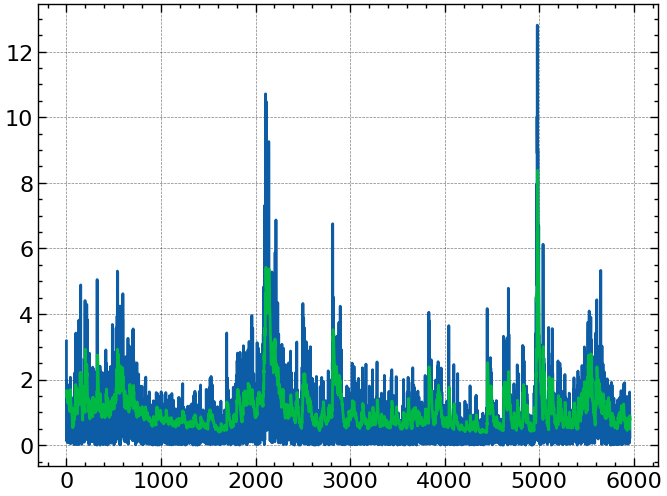

In [88]:
plt.plot(np.sqrt(actuals[1]))
plt.plot(np.sqrt(forecasts[1]))